# Init

In [1]:

import os
import pickle
import pandas as pd
# from postProcessingFunctions import processOutputs, replaceValueInFile, parallelizeFunction, genExtList
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gumbel_r, gumbel_l
from scipy.stats import genextreme

import re

import numpy as np

from IPython.display import display, Markdown

import moorpy as mp
import copy

from moorpy_functions import genMoorpySys2


In [2]:
resultsFol = r'..\results'
dataFol = r'..\data'

yamlFile = os.path.join(dataFol, "P200_C142_L1430_clump40.yaml")
sumDf_path = os.path.join(resultsFol, r"P200_C142_L1430_clump40_extreme.parquet")

anchorExtEventsDf_path = os.path.join(resultsFol, r"P200_C142_L1430_clump40_extreme_anchorExtremeEvents.parquet")
anchorExtStatsDf_path = os.path.join(resultsFol, r"P200_C142_L1430_clump40_extreme_anchorExtremeStats.parquet")
sumDf = pd.read_parquet(sumDf_path)
anchorExtEventsDf = pd.read_parquet(anchorExtEventsDf_path)
anchorExtStatsDf = pd.read_parquet(anchorExtStatsDf_path)
# ext_envCond = pd.read_excel(os.path.join(dataFol, r"envCond.xlsx"), index_col=0)

# anchorExtEventsDf = anchorExtEventsDf.droplevel(level=1)
# anchorExtStatsDf = anchorExtStatsDf.droplevel(level=1)

bodyYaml = os.path.join(dataFol, r"15MW_bdy.yaml")

1620674.240831974

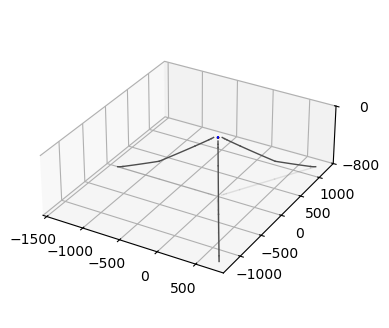

In [3]:

ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.plot()


ms.lineList[0].TA
# ms.lineList[0].TB

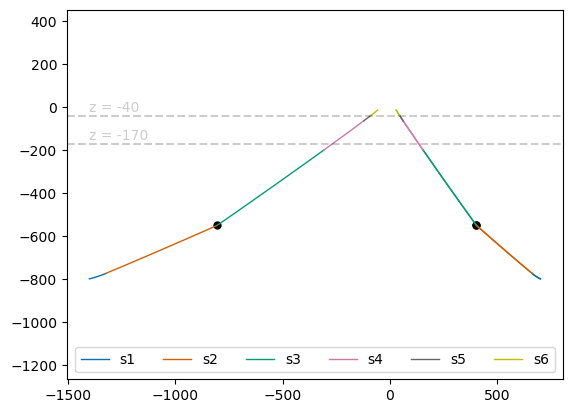

In [24]:

ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
fig, ax = plt.subplots(1, 1,)
ms.plot2d(ax = ax)
lines = ax.get_lines()

colGroups = {'s1' : ([1, 7, 13], '#0072B2'),
             's2' : ([2, 8, 14], '#D55E00'),
             's3' : ([3, 9, 15], '#009E73'),
             's4' : ([4, 10, 16], '#CC79A7'),
             's5' : ([5, 11, 17], '#666666'),
             's6' : ([6, 12, 18], 'y')}

legendList = []
for id in colGroups:
    for ind, i in enumerate(colGroups[id][0]):
        lines[i-1+3].set_color(colGroups[id][1]) #need to skip the first 3 as they are clumps
        if ind == 0:
            legendList.append(lines[i-1+3])
        
        

# ax.set_ylim(-900,)
ax.axhline(-170, color = 'k', linestyle = '--', alpha = 0.2)
ax.text(-1400, -170+20, 'z = -170', color = 'k', alpha = 0.2)

ax.axhline(-40, color = 'k', linestyle = '--', alpha = 0.2)
ax.text(-1400, -40+20, 'z = -40', color = 'k', alpha = 0.2)

#put legend outside the plot in
ax.legend(legendList, colGroups.keys(), loc = 'lower center', bbox_to_anchor=(0.5, 0), ncol = 6)


In [5]:
def extractInfoFromIndex(index):

    #Extract information about the run from the index
    match = re.match(r"Run_P(\d+)_C(\d+)_.*_([a-z,A-Z,\d,.,_]+)_(\d+)_S(\d+).*.outb", index)

    if match:
        return match.groups()
    else:
        raise ValueError(f"Index {index} does not match the pattern")




def checkDataFrame(df):
    if df.isna().any().any():
        raise ValueError("DataFrame contains NA values")
    

def displayDf(df, nCols = 5):

    for i in range(0, len(df.columns), nCols):
        display(Markdown(df.iloc[:, i:i+nCols].to_markdown()))



def checkTensionExtremes(sumDf, valHeader, valType='max', head=None):
    """
    Function which determines the critical tension to be considered 
    """
    
    # Select the max values from the DataFrame based on valType and valHeader
    df = sumDf.xs(valType, axis=1, level=1).loc[:, valHeader].copy()
     
    # Find the column with the max or min tension value for each row based on valType
    if valType == 'max':
        df['maxTenCol'] = df.idxmax(axis=1)
        df['maxTen'] = df.iloc[:,:-1].max(axis=1) # Exclude the last column which contains the name of the column with the max value
    elif valType == 'min':
        df['minTenCol'] = df.idxmin(axis=1)
        df['minTen'] = df.iloc[:,:-1].min(axis=1)
    else:
        raise ValueError("valType must be either 'max' or 'min'")
    
    # Add additional columns from the original DataFrame
    df['cond_head'] = sumDf['cond_head']
    df['seed'] = sumDf['seed']
    df['heading'] = sumDf['heading']
    df['polyDia'] = sumDf['polyDia']
    

    # Filter by the specified heading
    if head is not None:
        df = df[df['heading'] == head]

    if valType == 'max':
        val = df['maxTen'].max()
        loc = df['maxTen'].idxmax()
    elif valType == 'min':
        val = df['minTen'].min()
        loc = df['minTen'].idxmin()

    # Print unique maximum tension columns
    print(f'{valType} tensions occurring in {df[f"{valType}TenCol"].unique()} and val is {val} @ {loc}')
    
    return df



# ---------- Some Moorpy functions ----------

# def printMsStats(mpySys, topChainLineIndex, topChainLineIndex, waterDepth):

#     print('Body location')
#     print(f'{mpySys.bodyList[0].r6}')

#     topTenList = []

    
        
#         for ind, (lineId, pointId) in enumerate(zip(topChainLineIndex, bottomChainTopPointIndex)):

#             print(f'Line {ind + 1}')
#             if moorpyVersion == '1.1.0' :
#                 print(f'Top tension : {mpySys.lineList[lineId-1].getTension(s = 1)/1000:.2f} kN') #tension at the top of the chain - end B
#                 print(f'Anchor tension : {mpySys.lineList[lineId-1].getTension(s = 0)/1000:.2f} kN') #tension at the anchor - end A
#             else:
#                 print(f'Top tension : {mpySys.lineList[lineId-1].getLineTens()[-1]/1000:.2f} kN')
#                 print(f'Anchor tension : {mpySys.lineList[lineId-1].getLineTens()[0]/1000:.2f} kN')
#             print(f'z locaton of transition top of btm chain : {mpySys.pointList[pointId].r[2] + waterDepth:.2f} m')
#             topTenList.append(mpySys.lineList[lineId-1].getTension(s = 1))

#     else :

#         print('Body location')
#         print(f'{mpySys.bodyList[0].r6}')

#         print('Line 1')
#         print(f'Top tension : {mpySys.lineList[2].getLineTens()[-1]/1000:.2f} kN') #tension at the top of the chain - end B
#         print(f'Anchor tension : {mpySys.lineList[0].getLineTens()[0]/1000:.2f} kN') #tension at the anchor - end A
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[1].r[2] + 800:.2f} m')

#         print('Line 2')
#         print(f'Top tension : {mpySys.lineList[5].getLineTens()[-1]/1000:.2f} kN') 
#         print(f'Anchor tension : {mpySys.lineList[3].getLineTens()[0]/1000:.2f} kN')
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[5].r[2] + 800:.2f} m')

#         print('Line 3')
#         print(f'Top tension : {mpySys.lineList[8].getLineTens()[-1]/1000:.2f} kN') 
#         print(f'Anchor tension : {mpySys.lineList[6].getLineTens()[0]/1000:.2f} kN') 
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[9].r[2] + 800:.2f} m')
#         preTension = np.mean([mpySys.lineList[2].getLineTens()[-1], mpySys.lineList[5].getLineTens()[-1], mpySys.lineList[8].getLineTens()[-1]])
    
#     preTension = np.mean(topTenList)
#     print(f'Average top tension : {preTension/1000:.2f} kN')

#     return preTension



def getLineTensions(mpySys, lineIndexList, end = 'fA'):

    '''
    lineIndexList : list of line indices - the index as seen in the moorDyn file. The index starts at 1
    s = 0 for end A and s = -1 for end B
    '''

    tensionList = []
    for ind, lineId in enumerate(lineIndexList):


        ten = np.linalg.norm(getattr(mpySys.lineList[lineId-1], end))
        
        
        # ten = mpySys.lineList[lineId-1].getTension(s = s)
     
        # else :
        #     ten = mpySys.lineList[lineId-1].getLineTens()

        #     if s== 0 :
        #         ten = ten[0]
        #     elif s == 1 :
        #         ten = ten[-1]
        #     else :
        #         raise ValueError('s must be 0 or 1 for moorpy version < 1.1.0')

        # ten = mpySys.lineList[lineId-1].getTension(s = s)
        print(f'Line {ind + 1} : {ten/1000:.2f} kN')
        tensionList.append(ten)

    return tensionList



In [6]:
ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type

In [7]:
getLineTensions(ms, lineIndexList = [5], end = 'fB')

Line 1 : 1973.09 kN


[1973088.915947586]

In [8]:
#extract information form the index columns
for df in [sumDf, anchorExtStatsDf, anchorExtEventsDf]:

    if len(df.index[0]) != 1:
        index = df.index.get_level_values(0)
    else :
        index = df.index 
    df[['polyDia', 'chainDia', 'cond', 'heading', 'seed']] = index.map(extractInfoFromIndex).to_list()

    #additional modifications
    df['polyDia']        = df['polyDia'].astype(float)/1000 #convert to meters
    df['chainDia']       = df['chainDia'].astype(float)/1000 #convert to meters
    df['seed']           = df['seed'].str.replace(r'(\d+)', lambda x: x.group(0).zfill(2), regex=True) #change S1 to S01
    df['cond_head']      = df['cond'] + '_' + df['heading']
    df['heading']        = df['heading'].astype(float)

    #check for NA values
    checkDataFrame(df)

# Wave elevation

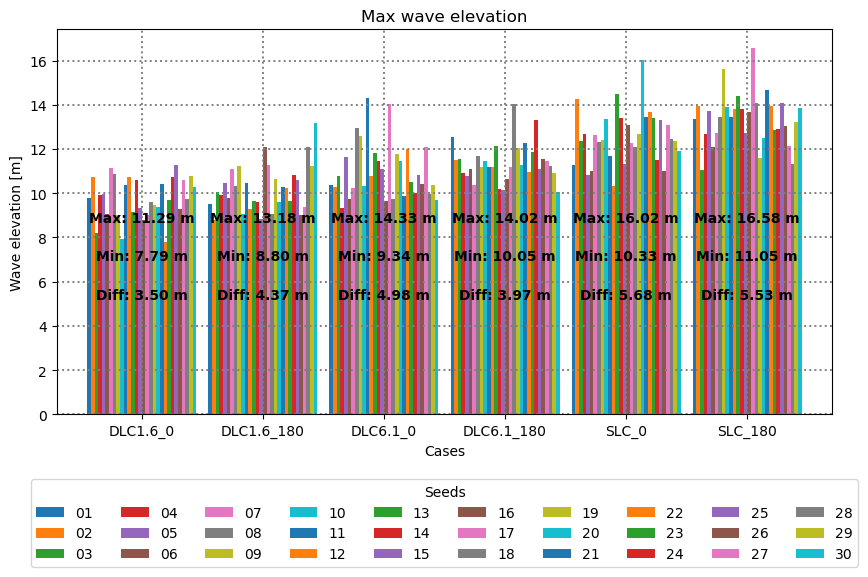

Max wave elevation [m]


| cond_head   |       01 |       02 |       03 |       04 |       05 |       06 |
|:------------|---------:|---------:|---------:|---------:|---------:|---------:|
| DLC1.6_0    |  9.80585 | 10.7538  |  8.18614 |  9.92399 |  9.96938 |  9.04955 |
| DLC1.6_180  |  9.50249 |  8.80403 | 10.0651  |  9.93606 | 10.4612  |  9.798   |
| DLC6.1_0    | 10.3822  | 10.2724  | 10.8002  |  9.34494 | 11.6351  |  9.7535  |
| DLC6.1_180  | 12.5225  | 11.4987  | 11.5516  | 10.927   | 10.759   | 11.1162  |
| SLC_0       | 11.2853  | 14.2734  | 12.3645  | 12.6866  | 10.8269  | 11.0135  |
| SLC_180     | 13.3456  | 13.9246  | 11.0521  | 12.665   | 13.7292  | 12.105   |

| cond_head   |      07 |      08 |       09 |       10 |      11 |       12 |
|:------------|--------:|--------:|---------:|---------:|--------:|---------:|
| DLC1.6_0    | 11.1255 | 10.8716 |  9.03576 |  7.91209 | 10.3914 | 10.7477  |
| DLC1.6_180  | 11.0996 | 10.3205 | 11.2162  |  9.07238 | 10.478  |  9.26512 |
| DLC6.1_0    | 10.2482 | 12.9402 | 12.5841  | 10.3288  | 14.328  | 10.7815  |
| DLC6.1_180  | 10.3536 | 11.703  | 11.2073  | 11.4552  | 11.1941 | 11.1692  |
| SLC_0       | 12.6463 | 12.3127 | 12.4019  | 13.3601  | 11.6877 | 10.3342  |
| SLC_180     | 12.709  | 13.451  | 15.6093  | 13.919   | 13.4308 | 13.7918  |

| cond_head   |       13 |       14 |       15 |       16 |       17 |       18 |
|:------------|---------:|---------:|---------:|---------:|---------:|---------:|
| DLC1.6_0    |  9.13058 | 10.6161  |  9.34561 |  8.80366 |  9.03151 |  9.59225 |
| DLC1.6_180  |  9.62842 |  9.62556 |  8.85767 | 12.0954  | 11.2717  |  9.07368 |
| DLC6.1_0    | 11.8416  | 11.4776  | 11.1125  |  9.64906 | 14.0346  |  9.72474 |
| DLC6.1_180  | 12.1499  | 10.2115  | 10.1426  | 10.6468  | 11.193   | 14.0228  |
| SLC_0       | 14.4772  | 13.4217  | 11.3398  | 13.1019  | 12.255   | 12.1128  |
| SLC_180     | 14.4054  | 13.817   | 12.7126  | 13.6575  | 16.5826  | 14.0943  |

| cond_head   |       19 |       20 |       21 |       22 |       23 |      24 |
|:------------|---------:|---------:|---------:|---------:|---------:|--------:|
| DLC1.6_0    |  9.44651 |  9.36828 | 10.4285  |  7.79097 |  9.70341 | 10.7492 |
| DLC1.6_180  | 10.6573  |  9.58398 | 10.2695  | 10.2455  |  9.66288 | 10.8466 |
| DLC6.1_0    | 11.7971  | 11.4629  |  9.85352 | 12.0111  | 10.5296  | 10.0317 |
| DLC6.1_180  | 12.0532  | 11.2796  | 12.2917  | 10.9827  | 11.8649  | 13.3258 |
| SLC_0       | 12.6673  | 16.017   | 13.4516  | 13.6658  | 13.4093  | 11.5228 |
| SLC_180     | 11.6126  | 12.5156  | 14.6825  | 13.9253  | 12.8405  | 12.9142 |

| cond_head   |      25 |       26 |       27 |       28 |      29 |       30 |
|:------------|--------:|---------:|---------:|---------:|--------:|---------:|
| DLC1.6_0    | 11.2865 |  9.28007 | 10.6078  |  9.75376 | 10.7742 | 10.2756  |
| DLC1.6_180  | 10.5868 |  9.02341 |  9.36088 | 12.0784  | 11.2548 | 13.1765  |
| DLC6.1_0    | 10.8303 | 10.4019  | 12.0812  |  9.95105 | 10.3821 |  9.69055 |
| DLC6.1_180  | 11.1077 | 11.5421  | 11.442   | 11.2257  | 10.9025 | 10.0501  |
| SLC_0       | 13.3155 | 11.0111  | 13.0822  | 12.4363  | 12.3523 | 11.9202  |
| SLC_180     | 14.0916 | 13.0276  | 12.1536  | 11.3431  | 13.2316 | 13.8695  |

| cond_head   |      min |     max |
|:------------|---------:|--------:|
| DLC1.6_0    |  7.79097 | 11.2865 |
| DLC1.6_180  |  8.80403 | 13.1765 |
| DLC6.1_0    |  9.34494 | 14.328  |
| DLC6.1_180  | 10.0501  | 14.0228 |
| SLC_0       | 10.3342  | 16.017  |
| SLC_180     | 11.0521  | 16.5826 |

In [90]:
valHeader = ['Wave1Elev']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']


pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='Wave1Elev')


# pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
# pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
# pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Cases')
plt.ylabel('Wave elevation [m]')
plt.xticks(rotation=0)
plt.title('Max wave elevation')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Max wave elevation [m]')
displayDf(pivot_df, nCols = 6)

# Caculate pretensions

## Installed

None
Top tensions are[2049.878495343124, 2046.400991927103, 2049.878495343742] kN
Average top tension is 2048.71932753799 kN
Body postion is [ 4.21225699e-01 -2.72746194e-12 -8.97441642e-01  1.08127350e-15
 -2.47712475e-02 -2.05363900e-14]


(<Figure size 600x400 with 1 Axes>, <Axes: >)

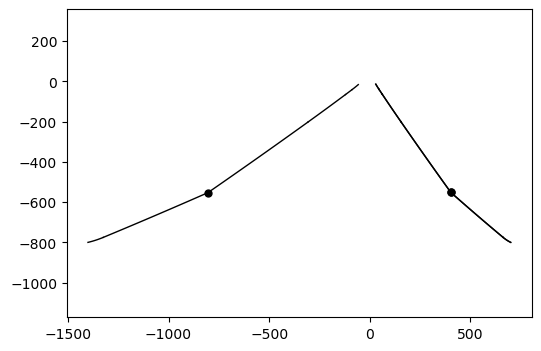

In [91]:
ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.bodyList[0].type = 0

conv = ms.solveEquilibrium3(tol=0.0001)
print(conv)

#Top tensions
topTen = [np.linalg.norm(ms.lineList[5].fB)/1000, np.linalg.norm(ms.lineList[11].fB)/1000, np.linalg.norm(ms.lineList[17].fB)/1000]

print(f'Top tensions are{topTen} kN')

print(f'Average top tension is {np.mean(topTen)} kN', )

print(f'Body postion is {ms.bodyList[0].r6}', )

ms.plot2d(color = 'k')

## Installation

Top tensions are[1080.3247167425325, 1078.2845399234159, 1080.3247167460559] kN
Average top tension is 1079.6446578040013 kN
Body postion is [ 4.78959986e-01 -5.58739779e-12 -4.84009618e-01  1.17228485e-16
 -2.56808622e-02  5.56718222e-18]


(<Figure size 600x400 with 1 Axes>, <Axes: >)

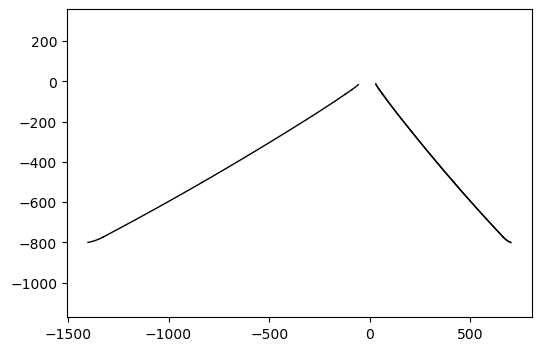

In [92]:


ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.bodyList[0].type = 0

for id in [3, 10, 17]: #set clump weights to zero
    ms.pointList[id-1].m = 0

conv = ms.solveEquilibrium3(tol=0.0001)

#Top tensions
topTen = [np.linalg.norm(ms.lineList[5].fB)/1000, np.linalg.norm(ms.lineList[11].fB)/1000, np.linalg.norm(ms.lineList[17].fB)/1000]

print(f'Top tensions are{topTen} kN')

print(f'Average top tension is {np.mean(topTen)} kN', )
print(f'Body postion is {ms.bodyList[0].r6}', )

ms.plot2d(color = 'k')

# Line properties

In [28]:
if sumDf['polyDia'].nunique() != 1 or sumDf['chainDia'].nunique() != 1:
    raise ValueError('Multiple MBLs for the same diameter')

polyDia = sumDf['polyDia'].unique()[0]
chainDia = sumDf['chainDia'].unique()[0]

linePropsDf = pd.read_csv(os.path.join(dataFol,r'lineProps.csv')) #get the line properties to calcualte the safety factor
polyDat = (linePropsDf['lineType'] == 'polyester') & (linePropsDf['dt_mg'] == 0.05) & (linePropsDf['dt_corr'] == 0) & (linePropsDf['nomDia'] == polyDia)
botChainDat = (linePropsDf['lineType'] == 'sl_chain') & (linePropsDf['dt_mg'] == 0.05) & (linePropsDf['dt_corr'] == 0.01) & (linePropsDf['nomDia'] == chainDia)
topChainDat = (linePropsDf['lineType'] == 'sl_chain') & (linePropsDf['dt_mg'] == 0.1) & (linePropsDf['dt_corr'] == 0.01) & (linePropsDf['nomDia'] == chainDia)

lineDf = linePropsDf.loc[polyDat | botChainDat | topChainDat, :]


polyMbl = lineDf.loc[polyDat, 'mbl'].values[0]

displayDf(lineDf, 5)




|     | lineType   |   nomDia |   dt_mg |   dt_corr |   massDensity |
|----:|:-----------|---------:|--------:|----------:|--------------:|
|  29 | polyester  |    0.2   |    0.05 |      0    |       79.1926 |
| 105 | sl_chain   |    0.142 |    0.05 |      0.01 |      483.202  |
| 108 | sl_chain   |    0.142 |    0.1  |      0.01 |      604.75   |

|     |   subWeight |   volEqDia |         mbl | EA                                    |   transDrag_eqDia |
|----:|------------:|-----------:|------------:|:--------------------------------------|------------------:|
|  29 |     184.861 |   0.273796 | 1.232e+07   | [172480000.00000003, (11.615, 0.396)] |           1.75313 |
| 105 |    3617.75  |   0.377003 | 1.56646e+07 | 1725925872.7815998                    |           1.54057 |
| 108 |    3887.72  |   0.508853 | 1.56646e+07 | 1725925872.7815998                    |           1.61304 |

|     |   longDrag_eqDia |   transAddedMass_eqDia |   longAddedMass_eqDia |
|----:|-----------------:|-----------------------:|----------------------:|
|  29 |         0        |                1.32063 |              0.180086 |
| 105 |         0.73819  |                1.33501 |              0.667507 |
| 108 |         0.772915 |                1.46357 |              0.731783 |

# Assumptions


- Line slackness check
  - SLC condition is considered for strength check of lines. Line slackness check fails for SLC condition -> pretension will have to be very high and higher line diameter will be required if this has to be satisfied.
- Only aligned WWC (wind wave current) has been considered - both along the line (0 deg. heading) and between the line (180 deg) condition is considered.
- Current modelling
  - Current loading on the platform accounted by applying a constant force calculated based on the surface current velocity and quadratic drag coefficient of the platform
  - Current loading on the mooring line is considered by considering a linear profile of the current velocity along the water depth 
- Wave loads acting on the mooring line is not considered.


# Mean line tension at fairlead

* Environment : WWC aligned, 0 deg heading
* Line considered : Line 2

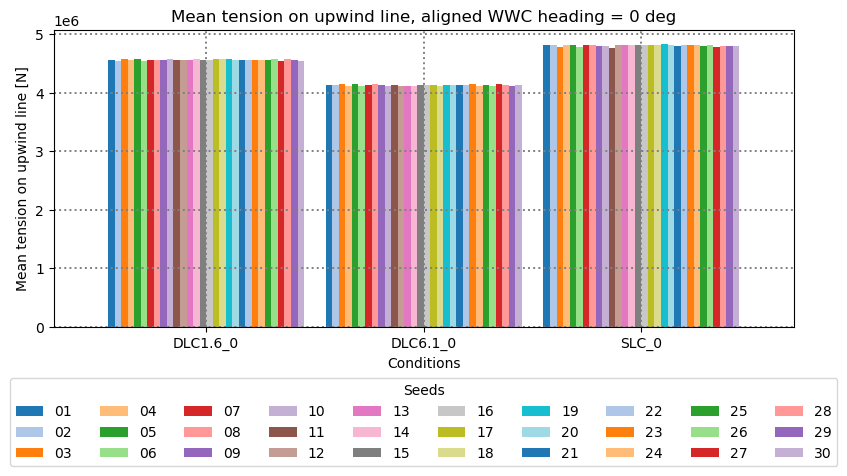

Mean tensions [N] on upwind line, aligned WWC heading = 0 deg


| cond_head   |          01 |          02 |          03 |          04 |          05 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.55303e+06 | 4.53518e+06 | 4.57819e+06 | 4.55274e+06 | 4.56974e+06 |
| DLC6.1_0    | 4.13316e+06 | 4.12662e+06 | 4.1417e+06  | 4.10863e+06 | 4.14124e+06 |
| SLC_0       | 4.82197e+06 | 4.80797e+06 | 4.77802e+06 | 4.80654e+06 | 4.80694e+06 |

| cond_head   |          06 |          07 |          08 |          09 |          10 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.54343e+06 | 4.55979e+06 | 4.56164e+06 | 4.56438e+06 | 4.5689e+06  |
| DLC6.1_0    | 4.1101e+06  | 4.12924e+06 | 4.14564e+06 | 4.12927e+06 | 4.11833e+06 |
| SLC_0       | 4.78384e+06 | 4.80712e+06 | 4.82128e+06 | 4.7969e+06  | 4.80525e+06 |

| cond_head   |          11 |          12 |          13 |          14 |          15 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.56375e+06 | 4.56138e+06 | 4.5616e+06  | 4.57868e+06 | 4.55736e+06 |
| DLC6.1_0    | 4.13568e+06 | 4.11903e+06 | 4.11693e+06 | 4.12093e+06 | 4.13014e+06 |
| SLC_0       | 4.76725e+06 | 4.80855e+06 | 4.80568e+06 | 4.80663e+06 | 4.81505e+06 |

| cond_head   |          16 |          17 |          18 |          19 |          20 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.55821e+06 | 4.5704e+06  | 4.57352e+06 | 4.56851e+06 | 4.56269e+06 |
| DLC6.1_0    | 4.13563e+06 | 4.13351e+06 | 4.11285e+06 | 4.12557e+06 | 4.12575e+06 |
| SLC_0       | 4.818e+06   | 4.80907e+06 | 4.81847e+06 | 4.83654e+06 | 4.81716e+06 |

| cond_head   |          21 |          22 |          23 |          24 |          25 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.56592e+06 | 4.56496e+06 | 4.55467e+06 | 4.55517e+06 | 4.56242e+06 |
| DLC6.1_0    | 4.12241e+06 | 4.12626e+06 | 4.14227e+06 | 4.11223e+06 | 4.13496e+06 |
| SLC_0       | 4.80189e+06 | 4.81543e+06 | 4.80566e+06 | 4.80636e+06 | 4.79772e+06 |

| cond_head   |          26 |          27 |          28 |          29 |          30 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.5687e+06  | 4.54844e+06 | 4.57047e+06 | 4.56014e+06 | 4.54704e+06 |
| DLC6.1_0    | 4.11464e+06 | 4.14249e+06 | 4.13155e+06 | 4.11921e+06 | 4.12563e+06 |
| SLC_0       | 4.81523e+06 | 4.78153e+06 | 4.80107e+06 | 4.79992e+06 | 4.80203e+06 |

MeanTension/MBL % = 36.51


In [94]:
valHeader = ['FAIRTEN12']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']

head = 0  #heading to be analyzed
maxPd = maxPd[maxPd['heading'] == head]


pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df.plot(kind='bar', figsize=(9, 5), width=0.9, color = plt.cm.tab20.colors)

plt.xlabel('Conditions')
# plt.ylabel('FAIRTEN6_max [N]')
plt.ylabel('Mean tension on upwind line [N]')
plt.xticks(rotation=0)
plt.title(f'Mean tension on upwind line, aligned WWC heading = {head} deg')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.tight_layout()
plt.show()

print(f"Mean tensions [N] on upwind line, aligned WWC heading = {head} deg")


displayDf(pivot_df, nCols = 5)

print(f'MeanTension/MBL % = {np.mean(pivot_df.values)/polyMbl * 100:.2f}')


# Max line tension at fairlead

* Environment : WWC aligned, 0 deg heading
* Line considered : Line 2

## Polyester

In [11]:
valHeader = [f'{ten}{ind}' for ind in range(7,13) for ten in ['ANCHTEN', 'FAIRTEN']]
valType   = 'max'
head = 0
maxPd = checkTensionExtremes(sumDf, valHeader, valType, head)
maxPd


max tensions occurring in ['FAIRTEN12'] and val is 7482550.0 @ Run_P200_C142_L1430_clump40_SLC_0_S17.outb


,ANCHTEN7,FAIRTEN7,ANCHTEN8,FAIRTEN8,ANCHTEN9,FAIRTEN9,ANCHTEN10,FAIRTEN10,ANCHTEN11,FAIRTEN11,ANCHTEN12,FAIRTEN12,maxTenCol,maxTen,cond_head,seed,heading,polyDia
Run_P200_C142_L1430_clump40_DLC1.6_0_S1.outb,5148544.5,5265301.0,5265275.0,5280489.5,5461248.0,5475674.0,5473725.5,5486772.5,5483849.0,5488875.5,5485019.5,5552057.5,FAIRTEN12,5552057.5,DLC1.6_0,01,0.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_0_S10.outb,4991285.0,5107883.0,5107856.0,5123816.0,5307887.5,5325182.0,5323971.0,5340792.0,5339013.5,5345032.0,5342702.5,5417279.0,FAIRTEN12,5417279.0,DLC1.6_0,10,0.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_0_S11.outb,5159191.0,5276253.5,5276244.0,5292386.5,5477200.0,5493837.5,5492473.0,5508277.0,5506159.5,5511868.5,5509066.0,5581383.0,FAIRTEN12,5581383.0,DLC1.6_0,11,0.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_0_S12.outb,5395323.5,5511986.0,5511947.5,5525843.5,5700473.0,5712131.5,5709489.0,5719162.0,5715225.5,5719465.5,5714297.5,5778221.0,FAIRTEN12,5778221.0,DLC1.6_0,12,0.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_0_S13.outb,5216427.5,5333260.5,5333240.0,5348977.0,5532157.0,5548195.5,5546724.5,5562071.0,5559880.5,5565502.5,5562614.5,5634982.5,FAIRTEN12,5634982.5,DLC1.6_0,13,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Run_P200_C142_L1430_clump40_SLC_0_S5.outb,6493614.5,6610840.0,6610810.5,6625284.0,6800252.5,6812291.0,6809842.0,6820528.0,6816830.5,6821416.5,6816568.0,6882023.0,FAIRTEN12,6882023.0,SLC_0,05,0.0,0.2
Run_P200_C142_L1430_clump40_SLC_0_S6.outb,6428348.5,6545221.0,6545190.5,6559304.0,6732537.0,6743324.5,6740526.0,6749362.0,6745075.5,6749136.0,6743506.0,6808769.5,FAIRTEN12,6808769.5,SLC_0,06,0.0,0.2
Run_P200_C142_L1430_clump40_SLC_0_S7.outb,6306743.0,6422598.0,6422557.5,6436032.0,6606037.0,6615343.5,6612163.0,6623539.5,6620064.0,6624782.0,6620200.5,6686579.0,FAIRTEN12,6686579.0,SLC_0,07,0.0,0.2
Run_P200_C142_L1430_clump40_SLC_0_S8.outb,7050412.0,7168082.0,7168054.0,7181839.5,7353316.5,7362927.0,7359896.0,7367159.0,7362481.0,7366197.0,7360042.5,7419490.5,FAIRTEN12,7419490.5,SLC_0,08,0.0,0.2


In [17]:
valHeader = ['FAIRTEN12']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['maxTenCol']  = maxPd.idxmax(axis = 1)
maxPd['maxTenVal']  = maxPd.iloc[:,:-1].max(axis = 1)
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']
maxPd['polyDia']    = sumDf['polyDia']


#only heading = 0 is of interest
head = 0  #heading to be analyzed
maxPd = maxPd[maxPd['heading'] == head]

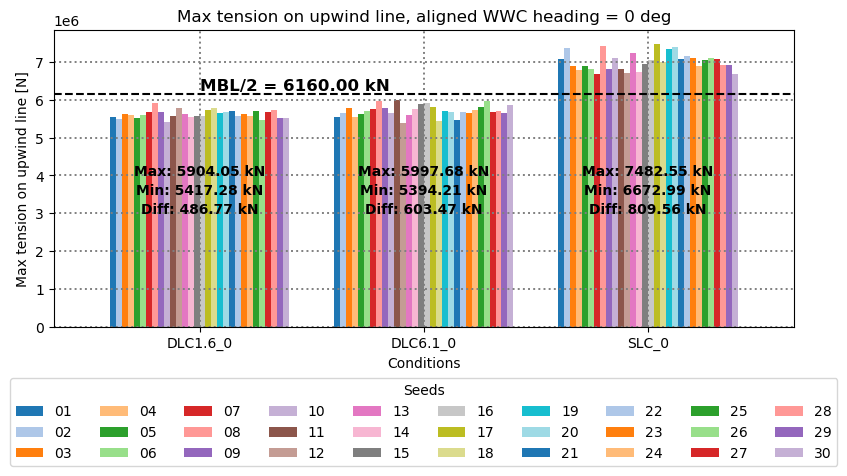

Max tensions [N] on upwind line, aligned WWC heading = 0 deg


| cond_head   |          01 |          02 |          03 |          04 |          05 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.55206e+06 | 5.49786e+06 | 5.61973e+06 | 5.60318e+06 | 5.50984e+06 |
| DLC6.1_0    | 5.55226e+06 | 5.6437e+06  | 5.78565e+06 | 5.54859e+06 | 5.61836e+06 |
| SLC_0       | 7.08918e+06 | 7.36615e+06 | 6.8852e+06  | 6.7801e+06  | 6.88202e+06 |

| cond_head   |          06 |          07 |          08 |          09 |          10 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.59549e+06 | 5.67925e+06 | 5.90405e+06 | 5.66863e+06 | 5.41728e+06 |
| DLC6.1_0    | 5.69665e+06 | 5.75613e+06 | 5.96217e+06 | 5.76805e+06 | 5.65673e+06 |
| SLC_0       | 6.80877e+06 | 6.68658e+06 | 7.41949e+06 | 6.80837e+06 | 7.09617e+06 |

| cond_head   |          11 |          12 |          13 |          14 |          15 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.58138e+06 | 5.77822e+06 | 5.63498e+06 | 5.54605e+06 | 5.56767e+06 |
| DLC6.1_0    | 5.99768e+06 | 5.39421e+06 | 5.60648e+06 | 5.74994e+06 | 5.89788e+06 |
| SLC_0       | 6.82382e+06 | 6.69862e+06 | 7.23229e+06 | 6.74569e+06 | 6.93652e+06 |

| cond_head   |          16 |          17 |          18 |          19 |          20 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.56318e+06 | 5.71562e+06 | 5.76956e+06 | 5.64657e+06 | 5.67059e+06 |
| DLC6.1_0    | 5.92488e+06 | 5.81218e+06 | 5.43887e+06 | 5.69258e+06 | 5.67145e+06 |
| SLC_0       | 7.03804e+06 | 7.48255e+06 | 6.99428e+06 | 7.34977e+06 | 7.38554e+06 |

| cond_head   |          21 |          22 |          23 |          24 |          25 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.69983e+06 | 5.55803e+06 | 5.62979e+06 | 5.56965e+06 | 5.70161e+06 |
| DLC6.1_0    | 5.47551e+06 | 5.68417e+06 | 5.65432e+06 | 5.74081e+06 | 5.80407e+06 |
| SLC_0       | 7.08187e+06 | 7.14829e+06 | 7.10454e+06 | 6.90441e+06 | 7.05982e+06 |

| cond_head   |          26 |          27 |          28 |          29 |          30 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.45784e+06 | 5.68166e+06 | 5.71715e+06 | 5.52081e+06 | 5.51799e+06 |
| DLC6.1_0    | 5.97433e+06 | 5.6875e+06  | 5.7117e+06  | 5.63941e+06 | 5.86141e+06 |
| SLC_0       | 7.11406e+06 | 7.06447e+06 | 6.928e+06   | 6.91732e+06 | 6.67299e+06 |

| cond_head   |   gumbel_loc |   gumbel_scale |         max |         min |
|:------------|-------------:|---------------:|------------:|------------:|
| DLC1.6_0    |  5.57025e+06 |          90983 | 5.90405e+06 | 5.41728e+06 |
| DLC6.1_0    |  5.63872e+06 |         145872 | 5.99768e+06 | 5.39421e+06 |
| SLC_0       |  6.9097e+06  |         188592 | 7.48255e+06 | 6.67299e+06 |

In [18]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df.plot(kind='bar', figsize=(9, 5), width=0.8, color = plt.cm.tab20.colors)

plt.ylabel('Max tension on upwind line [N]')
plt.xticks(rotation=0)
plt.title(f'Max tension on upwind line, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.tight_layout()

seedColNames = pivot_df.columns
pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
pivot_df['max'] = pivot_df[seedColNames].max(axis=1) #these two should be after the gumbel fit !!!! -otherwise
pivot_df['min'] = pivot_df[seedColNames].min(axis=1)

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]/1000:.2f} kN', xy=(x_coord, 4e6),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]/1000:.2f} kN', xy=(x_coord, 3.5e6),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"])/1000:.2f} kN', xy=(x_coord, 3e6),
                 ha='center', color='k', weight='bold')

 

plt.axhline(y=polyMbl/2, color='black', linestyle='--')
plt.text(0,polyMbl/2+0.1e6, f'MBL/2 = {polyMbl/2/1000:.2f} kN', fontsize=12, ha='left', weight='bold')

plt.show()



print(f"Max tensions [N] on upwind line, aligned WWC heading = {head} deg")
displayDf(pivot_df, nCols = 5)

## Max tension gumbel fit seed convergence

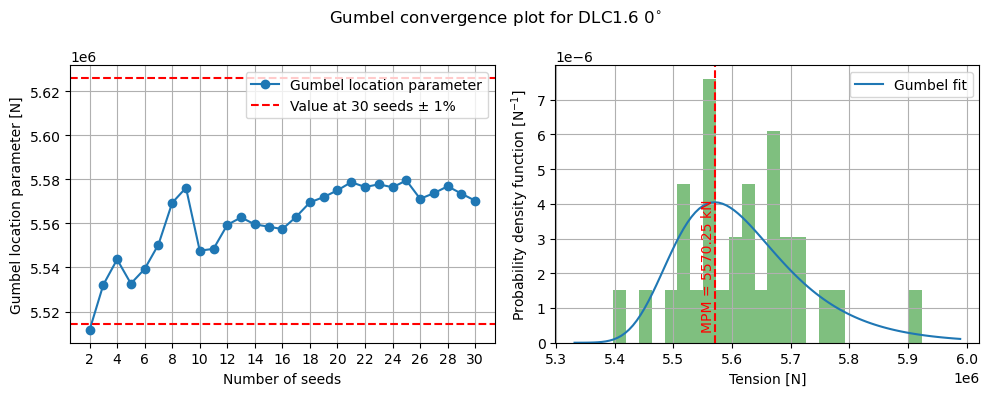

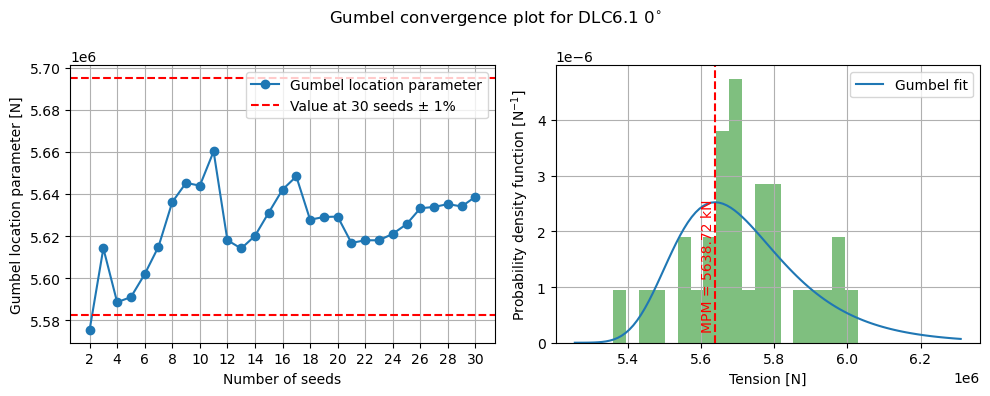

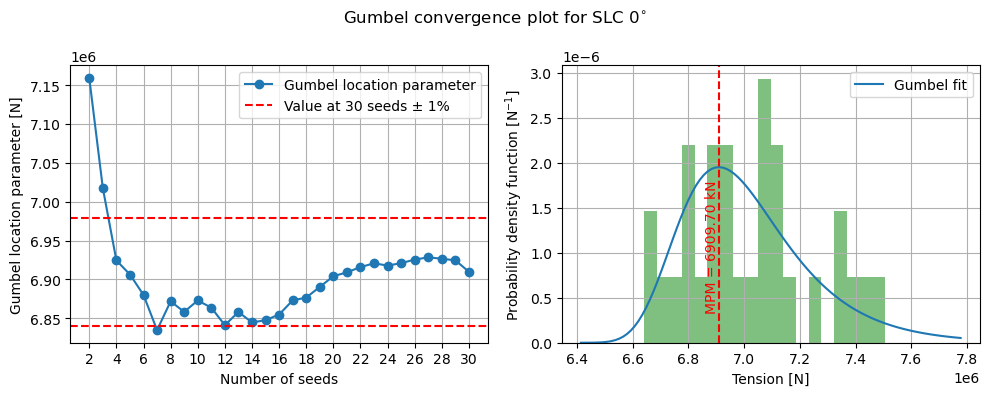

In [12]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
nSeeds = pivot_df.shape[1]

gumbel_locDict = {}
gev_fitDict = {}
maxValsDict = {}

condRenameDict = {}


dlcDict = { 'DLC1.6_0' : r'DLC1.6 $ 0 ^{\circ}$', 
            'DLC1.6_180' : r'DLC1.6 $ 180 ^{\circ}$', 
            'DLC6.1_0' : r'DLC6.1 $ 0 ^{\circ}$', 
            'DLC6.1_180' : r'DLC6.1 $ 180 ^{\circ}$', 
            'SLC_0' : r'SLC $ 0 ^{\circ}$', 
            'SLC_180' : r'SLC $ 180 ^{\circ}$'}



for index, row in pivot_df.iterrows():
    
    maxTenVals = row.values
    
    gumbel_locList = []
    gumbel_scaleList = []
    gumbel_seedList = []

    for i in range(2, len(maxTenVals)+1):
        val = maxTenVals[0:i]
        gumbel_loc, gumbel_scale = gumbel_r.fit(val)
        gumbel_locList.append(gumbel_loc)
        gumbel_scaleList.append(gumbel_scale)
        gumbel_seedList.append(len(val))

    gumbel_locDict[index] = [np.array(gumbel_seedList, dtype=np.int64), np.array(gumbel_locList), np.array(gumbel_scaleList)]

    #also do a GEV fit
    scaledParams = np.array(genextreme.fit(maxTenVals/1e6))  #scale the values to avoid numerical issues
    scaledParams[1:] = scaledParams[1:]*1e6 #leave out teh shape parameter which is not scaled
    gev_fitDict[index] = scaledParams

    maxValsDict[index] = maxTenVals
    

for ind, cond in enumerate(gumbel_locDict.keys()):

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    fig.suptitle(f'Gumbel convergence plot for {dlcDict[cond]}')
    
    #gumbel convergence plot
    plt.sca(axs[0])
    plt.plot(gumbel_locDict[cond][0], gumbel_locDict[cond][1], '-o', label = 'Gumbel location parameter')
    tolPercent = 1
    plt.axhline(y = (1 +  tolPercent/100) * gumbel_locDict[cond][1][-1], color='red', linestyle='--', label=f'Value at {nSeeds} seeds ± {tolPercent}%')
    plt.axhline(y = (1 -  tolPercent/100) * gumbel_locDict[cond][1][-1], color='red', linestyle='--')
    plt.xticks(range(2, len(gumbel_locDict[cond][0])+2, 2))
    plt.grid()
    plt.legend()
    plt.xlabel('Number of seeds')
    plt.ylabel('Gumbel location parameter [N]')



    #gumbel pdf
    plt.sca(axs[1])
    gumbel_loc = gumbel_locDict[cond][1][-1]
    gumbel_scale = gumbel_locDict[cond][2][-1]
    x = np.linspace(gumbel_r.ppf(1e-6, scale=gumbel_scale, loc=gumbel_loc),
                    gumbel_r.ppf(0.99, scale=gumbel_scale, loc=gumbel_loc), 100)
    y = gumbel_r.pdf(x, scale=gumbel_scale, loc=gumbel_loc)
    plt.plot(x, y, label='Gumbel fit')
    y_min, y_max = plt.ylim()
    plt.text(gumbel_loc, np.max(y_max - y_min)/2, 
            f"MPM = {gumbel_loc/1000:.2f} kN", rotation=90, ha='right', va='center', color='r')
    plt.axvline(gumbel_loc, color='r', linestyle='--')
    plt.grid()
    plt.xlabel('Tension [N]')
    plt.ylabel(r'Probability density function [N$^{-1}$]')

    #plot the GEV fit
    # gev_fit = gev_fitDict[cond]
    # y_gev = genextreme.pdf(x, c=gev_fit[0], loc=gev_fit[1], scale=gev_fit[2])
    # print(f'Cond {cond} : Shape = {gev_fit[0]:.2f}, Location = {gev_fit[1]:.2f}, Scale = {gev_fit[2]:.2f}')
    # plt.plot(x, y_gev, label='GEV fit')

    #plot histogram
    plt.hist(maxValsDict[cond], bins=30, density=True, alpha=0.5, color='g', range=(x.min(), x.max()))

    plt.legend()

    fig.tight_layout()


### Safety factor check on MPM value

In [13]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')

#gumbel fit
fit_df = pd.DataFrame()
fit_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
fit_df['gumbel_90Quantile'] = fit_df.apply(lambda row: gumbel_r.ppf(0.90, loc=row['gumbel_loc'], scale=row['gumbel_scale']), axis=1)
# pivot_df

#GEV fit
normaliseFact = 1e6 #for GEV fit the data needs to be normalised
fit_df[['gev_shape', 'gev_loc', 'gev_scale']] = pivot_df.apply(lambda row: pd.Series(genextreme.fit(row.values/normaliseFact)), axis=1)
fit_df['gev_loc'] = fit_df['gev_loc']*normaliseFact #scale them back
fit_df['gev_scale'] = fit_df['gev_scale']*normaliseFact 
fit_df['gev_90Quantile'] = fit_df.apply(lambda row: genextreme.ppf(0.90, c=row['gev_shape'], loc=row['gev_loc'], scale=row['gev_scale']), axis=1)

# pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
# pivot_df

Text(1.6, 1.07, 'Safety factor = 1.05')

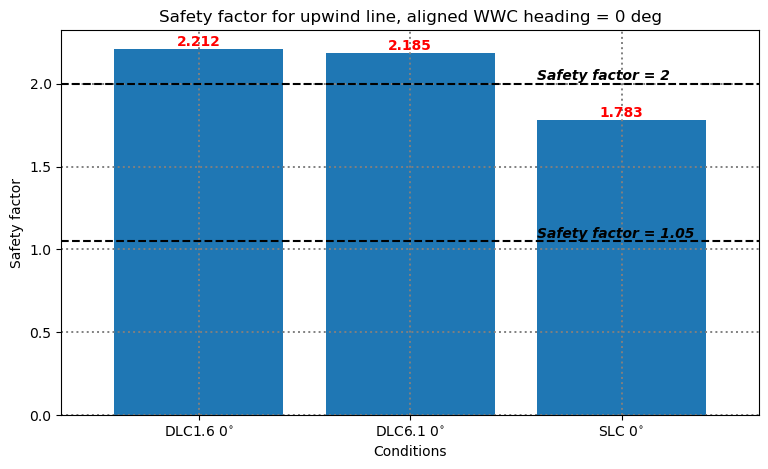

In [19]:
dlcDict = { 'DLC1.6_0' : r'DLC1.6 $ 0 ^{\circ}$', 
            'DLC1.6_180' : r'DLC1.6 $ 180 ^{\circ}$', 
            'DLC6.1_0' : r'DLC6.1 $ 0 ^{\circ}$', 
            'DLC6.1_180' : r'DLC6.1 $ 180 ^{\circ}$', 
            'SLC_0' : r'SLC $ 0 ^{\circ}$', 
            'SLC_180' : r'SLC $ 180 ^{\circ}$'}


pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
# pivot_df['90Quantile'] = pivot_df.apply(lambda row: gumbel_r.ppf(0.90, loc=row['gumbel_loc'], scale=row['gumbel_scale']), axis=1)

#plot the dataframe
safetyDf = polyMbl/pivot_df[['gumbel_loc']]
# safetyDf = polyMbl/fit_df[['gev_90Quantile']]

safetyDf.plot(kind='bar', figsize=(9, 5), width=0.8)
plt.xticks(rotation=0)
plt.gca().set_xticklabels([dlcDict[label] for label in safetyDf.index])
plt.title(f'Safety factor for upwind line, aligned WWC heading = {head} deg')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.legend().remove()
plt.ylabel(r'Safety factor')
plt.xlabel('Conditions')

for i in range(len(safetyDf)):
    for j in range(len(safetyDf.columns)):
        value = safetyDf.iloc[i, j]  # Get the value from the DataFrame
        plt.annotate(f'{value:.3f}', xy=(i, value), ha='center', va='bottom', color='r', weight='bold')

plt.axhline(y=2, color='k', linestyle='--')
plt.axhline(y=1.05, color='k', linestyle='--')
plt.annotate('Safety factor = 2', xy=(1.6, 2.02), fontstyle='italic', color='k', weight='bold')
plt.annotate('Safety factor = 1.05', xy=(1.6, 1.07), fontstyle='italic', color='k', weight='bold')

In [15]:
pivot_df[['gumbel_loc']]

seed,gumbel_loc
cond_head,
DLC1.6_0,5.570247e+06
DLC6.1_0,5.638722e+06
SLC_0,6.909700e+06


In [17]:
polyMbl/pivot_df[['gumbel_loc']]

seed,gumbel_loc
cond_head,
DLC1.6_0,2.211751
DLC6.1_0,2.184892
SLC_0,1.783001


In [18]:
polyMbl

12320000.000000002

# Minimum line tension at anchor

In [101]:
valHeader =  [f'{ten}{ind}' for ind in range(7,13) for ten in ['ANCHTEN', 'FAIRTEN']]
valType   = 'min'
head = 180
minPd = checkTensionExtremes(sumDf, valHeader, valType, head)
minPd


min tensions occurring in ['ANCHTEN7'] and val is 86459.1796875 @ Run_P200_C142_L1430_clump40_SLC_180_S30.outb


,ANCHTEN7,FAIRTEN7,ANCHTEN8,FAIRTEN8,ANCHTEN9,FAIRTEN9,ANCHTEN10,FAIRTEN10,ANCHTEN11,FAIRTEN11,ANCHTEN12,FAIRTEN12,minTenCol,minTen,cond_head,seed,heading,polyDia
Run_P200_C142_L1430_clump40_DLC1.6_180_S1.outb,411607.187500,428941.937500,429260.00000,444271.40625,649157.12500,681012.31250,681873.56250,716042.9375,717530.8750,728656.4375,730520.8125,814995.8750,ANCHTEN7,411607.187500,DLC1.6_180,01,180.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_180_S10.outb,444746.000000,464737.281250,465067.31250,480102.65625,683363.25000,713719.00000,714647.31250,748169.3750,749320.2500,759935.3125,761422.8750,846992.8750,ANCHTEN7,444746.000000,DLC1.6_180,10,180.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_180_S11.outb,378595.781250,407827.468750,408469.87500,426202.03125,631252.93750,664130.06250,665707.12500,702755.4375,704888.5000,716659.3125,719311.3125,798134.0625,ANCHTEN7,378595.781250,DLC1.6_180,11,180.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_180_S12.outb,415263.812500,432285.156250,432586.87500,447416.96875,652667.37500,684091.12500,685070.81250,719294.1250,720740.5000,731792.6250,733692.0625,818527.8125,ANCHTEN7,415263.812500,DLC1.6_180,12,180.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_180_S13.outb,427940.468750,451284.812500,453213.62500,467903.25000,672369.50000,703563.81250,704419.37500,737830.3125,739039.6875,749773.0000,751290.9375,834904.8750,ANCHTEN7,427940.468750,DLC1.6_180,13,180.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Run_P200_C142_L1430_clump40_SLC_180_S5.outb,274900.187500,285108.343750,285397.71875,304146.93750,508639.21875,539769.18750,540684.50000,574945.5000,576003.5625,586788.6875,588027.1250,667459.8750,ANCHTEN7,274900.187500,SLC_180,05,180.0,0.2
Run_P200_C142_L1430_clump40_SLC_180_S6.outb,251414.218750,262076.921875,262440.21875,284874.59375,487646.46875,518132.68750,519348.34375,554542.6250,556175.2500,567620.1875,569734.2500,638251.3750,ANCHTEN7,251414.218750,SLC_180,06,180.0,0.2
Run_P200_C142_L1430_clump40_SLC_180_S7.outb,264543.562500,291469.375000,292016.21875,311896.31250,515520.50000,546839.25000,547768.93750,582137.8125,583640.5000,594825.6875,596785.9375,677385.9375,ANCHTEN7,264543.562500,SLC_180,07,180.0,0.2
Run_P200_C142_L1430_clump40_SLC_180_S8.outb,222255.203125,249598.828125,250416.59375,277765.21875,481680.03125,511282.09375,512669.56250,549625.5000,551851.1875,563704.2500,566677.5625,623476.0000,ANCHTEN7,222255.203125,SLC_180,08,180.0,0.2


* WWC aligned, 0 deg heading for Line 1 and 3
* WWC aligned, 180 deg heading for Line 2

In [102]:
valHeader = ['ANCHTEN1', 'ANCHTEN7', 'ANCHTEN13']
valType   = 'min'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() 
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']


linHeadDict = {'ANCHTEN1': 0, 
               'ANCHTEN7': 180, 
               'ANCHTEN13': 0}

lineNamesDict = {'ANCHTEN1' : 'Line 1', 
             'ANCHTEN7' : 'Line 2', 
             'ANCHTEN13' : 'Line 3'}

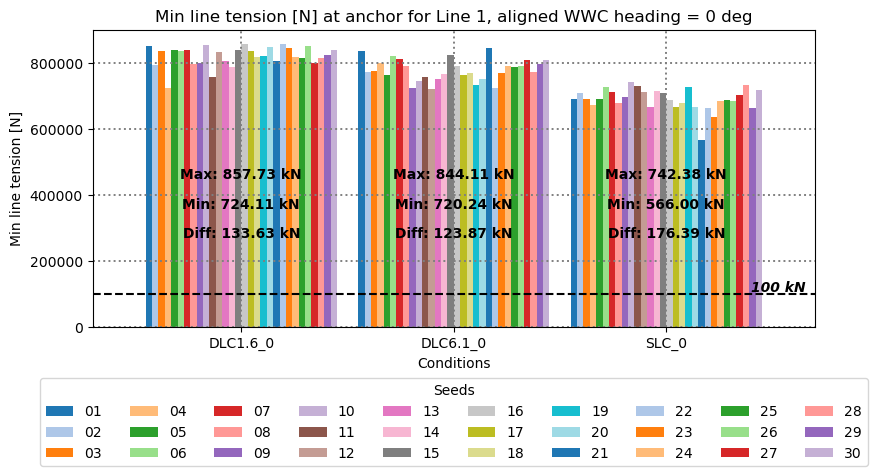

Min line tension [N] at anchor for Line 1, aligned WWC heading = 0 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 850549 | 793822 | 835451 | 724109 | 838432 | 834955 |
| DLC6.1_0    | 834851 | 770651 | 775450 | 799238 | 761909 | 819972 |
| SLC_0       | 690187 | 707363 | 689405 | 670922 | 691175 | 725348 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 839387 | 795841 | 797928 | 854519 | 757722 | 832845 |
| DLC6.1_0    | 812642 | 789303 | 724322 | 744940 | 756506 | 720239 |
| SLC_0       | 712042 | 677345 | 694648 | 742385 | 729129 | 711936 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 803863 | 787126 | 838694 | 857683 | 834978 | 817014 |
| DLC6.1_0    | 751616 | 764548 | 822715 | 788609 | 762768 | 768911 |
| SLC_0       | 665245 | 714166 | 709362 | 687354 | 665328 | 677455 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 821028 | 847299 | 805438 | 857734 | 844459 | 818778 |
| DLC6.1_0    | 733820 | 749789 | 844112 | 723789 | 767533 | 790599 |
| SLC_0       | 726224 | 665561 | 565996 | 662163 | 635013 | 685087 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |     30 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 812816 | 850240 | 798862 | 814954 | 823426 | 838713 |
| DLC6.1_0    | 785852 | 789207 | 809079 | 770854 | 796969 | 807158 |
| SLC_0       | 687512 | 685252 | 701733 | 731424 | 663455 | 716821 |

| cond_head   |    min |    max |
|:------------|-------:|-------:|
| DLC1.6_0    | 724109 | 857734 |
| DLC6.1_0    | 720239 | 844112 |
| SLC_0       | 565996 | 742385 |

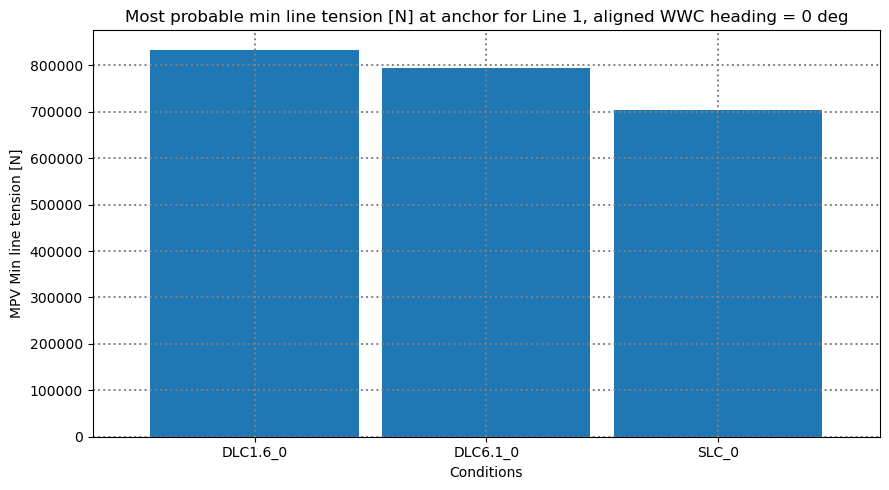

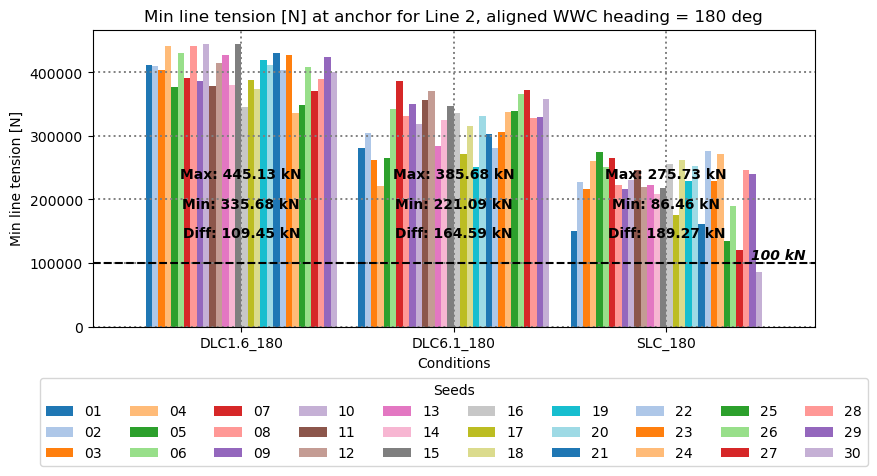

Min line tension [N] at anchor for Line 2, aligned WWC heading = 180 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 411607 | 409276 | 404289 | 442073 | 376783 | 429830 |
| DLC6.1_180  | 281318 | 303869 | 262483 | 221087 | 265390 | 342201 |
| SLC_180     | 150782 | 226831 | 217046 | 260083 | 274900 | 251414 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 391496 | 441606 | 386559 | 444746 | 378596 | 415264 |
| DLC6.1_180  | 385676 | 332045 | 349636 | 318520 | 356033 | 369991 |
| SLC_180     | 264544 | 222255 | 217165 | 230096 | 246340 | 219738 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 427940 | 380871 | 445128 | 345275 | 387885 | 374176 |
| DLC6.1_180  | 284864 | 324494 | 347826 | 336563 | 271109 | 315862 |
| SLC_180     | 223181 | 208879 | 218397 | 256263 | 175110 | 261479 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 419400 | 412289 | 430602 | 404466 | 427432 | 335681 |
| DLC6.1_180  | 250442 | 331973 | 302518 | 280487 | 305995 | 337755 |
| SLC_180     | 228717 | 252476 | 162120 | 275730 | 228324 | 271462 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |       30 |
|:------------|-------:|-------:|-------:|-------:|-------:|---------:|
| DLC1.6_180  | 348496 | 408254 | 371379 | 390025 | 423578 | 400946   |
| DLC6.1_180  | 339744 | 365785 | 372423 | 328443 | 329141 | 357710   |
| SLC_180     | 134179 | 189123 | 120823 | 246879 | 239434 |  86459.2 |

| cond_head   |      min |    max |
|:------------|---------:|-------:|
| DLC1.6_180  | 335681   | 445128 |
| DLC6.1_180  | 221087   | 385676 |
| SLC_180     |  86459.2 | 275730 |

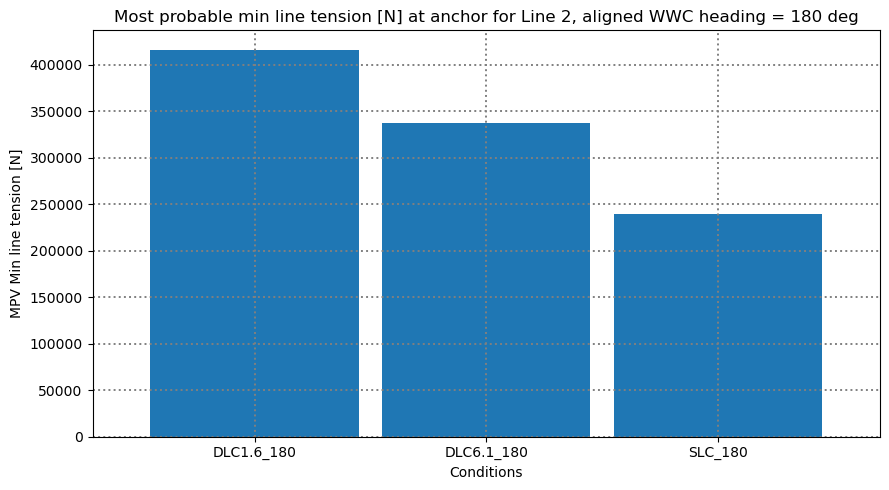

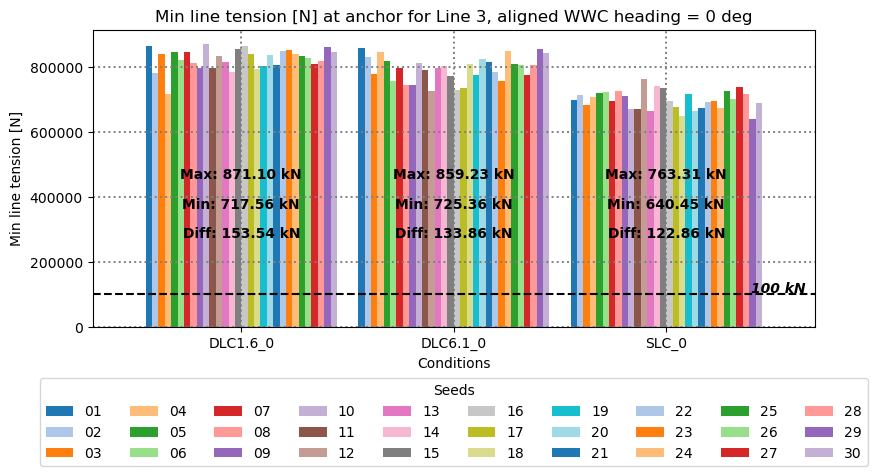

Min line tension [N] at anchor for Line 3, aligned WWC heading = 0 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 863742 | 781440 | 838191 | 717564 | 845558 | 819634 |
| DLC6.1_0    | 859226 | 828793 | 778834 | 846865 | 818255 | 756314 |
| SLC_0       | 698779 | 714202 | 681723 | 705812 | 720712 | 721958 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 845570 | 811287 | 796236 | 871099 | 795149 | 832860 |
| DLC6.1_0    | 797650 | 745018 | 743918 | 810698 | 789221 | 725363 |
| SLC_0       | 694133 | 724847 | 708551 | 670470 | 670152 | 763313 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 814095 | 785316 | 855324 | 863442 | 839265 | 792982 |
| DLC6.1_0    | 795585 | 802026 | 772280 | 729415 | 733755 | 807067 |
| SLC_0       | 664171 | 739320 | 734614 | 695002 | 675084 | 648848 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 803530 | 836611 | 805636 | 850074 | 852687 | 838518 |
| DLC6.1_0    | 774321 | 824947 | 813749 | 783189 | 756453 | 848726 |
| SLC_0       | 715267 | 662849 | 672220 | 691184 | 693157 | 671558 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |     30 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 834191 | 827855 | 808681 | 816516 | 860408 | 844018 |
| DLC6.1_0    | 808228 | 805031 | 775349 | 804647 | 854294 | 843380 |
| SLC_0       | 724228 | 701610 | 738500 | 714883 | 640455 | 687572 |

| cond_head   |    min |    max |
|:------------|-------:|-------:|
| DLC1.6_0    | 717564 | 871099 |
| DLC6.1_0    | 725363 | 859226 |
| SLC_0       | 640455 | 763313 |

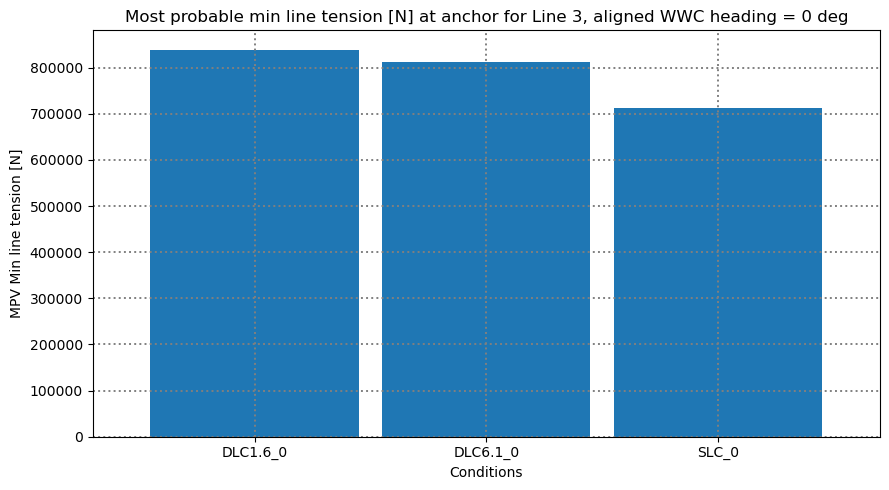

In [103]:
for lineID, head in linHeadDict.items():

    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()

    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)

    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'Min line tension [N]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
    plt.tight_layout()
    


    #minimum tensions
    pivot_df['min'] = pivot_df.min(axis=1)
    pivot_df['max'] = pivot_df.max(axis=1)

    dist =  np.mean(plt.ylim()) * 0.2

    for index, row in pivot_df.iterrows():
        x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
        plt.annotate(f'Max: {row["max"]/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim())),
                    ha='center', color='k', weight='bold')
        plt.annotate(f'Min: {row["min"]/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                    ha='center', color='k', weight='bold')
        #difference
        plt.annotate(f'Diff: {(row["max"]-row["min"])/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                    ha='center', color='k', weight='bold')
 
    plt.axhline(y = 100*1e3, color='k', linestyle='--')
    xLims = plt.xlim() 
    plt.text(xLims[1] -.3, 1.06 * 100*1e3, '100 kN', fontstyle='italic', color='k', weight='bold')
    plt.show()

    print(f"Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg")
    displayDf(pivot_df, nCols = 6)


    


    #------------ plot the most probable minimum tension value -----------
    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()

    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)

    pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_l.fit(row.values)), axis=1)

    pivot_df = pivot_df[['gumbel_loc']]

    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Most probable min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'MPV Min line tension [N]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.tight_layout()
    plt.legend().remove()


    # plt.axhline(y=0.1*preTension, color='k', linestyle='--')
    # plt.annotate('10% of Pretension', xy=(1.6, 1.02 * 0.1 * preTension), fontstyle='italic', color='k', weight='bold')


    

* The min tensions at anchor goes slack for SLC condition eventhough it shows 21.8 kN -> not able to find the reason for this small value to be always present.

# Minimum height of botom chain top node from the seabed

* WWC aligned, 0 deg heading for Line 1 and 3
* WWC aligned, 180 deg heading for Line 2

In [104]:
waterDepth = 800
valHeader = ['CON2PZ', 'CON9PZ', 'CON16PZ']
valType   = 'min'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() + waterDepth #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']


linHeadDict = {'CON2PZ': 0, 
               'CON9PZ': 180, 
               'CON16PZ': 0}

lineNamesDict = {   'CON2PZ' : 'Line 1', 
                    'CON9PZ': 'Line 2', 
                    'CON16PZ' : 'Line 3'}

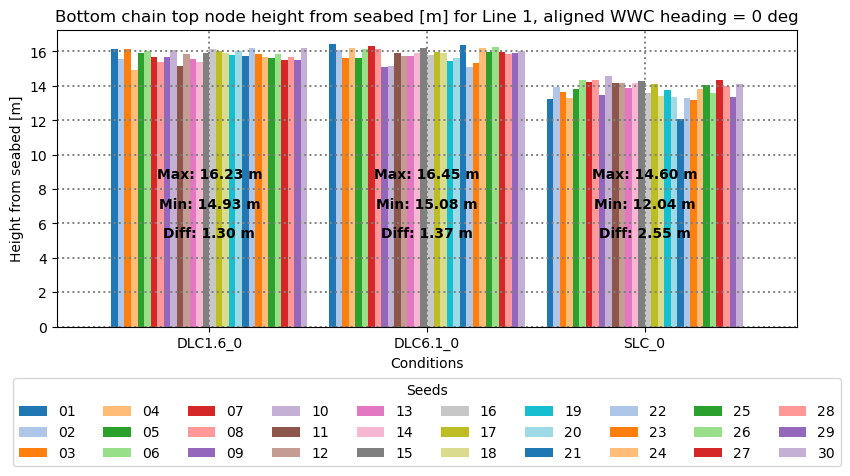

Min line tension [N] at anchor for Line 1, aligned WWC heading = 0 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.1637 | 15.5677 | 16.1575 | 14.9277 | 15.9203 | 16.053  |
| DLC6.1_0    | 16.4532 | 16.0649 | 15.6327 | 16.1865 | 15.619  | 16.1678 |
| SLC_0       | 13.2197 | 13.9227 | 13.6664 | 13.2862 | 13.8333 | 14.3202 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.6859 | 15.3807 | 15.6504 | 16.111  | 15.1428 | 15.852  |
| DLC6.1_0    | 16.3337 | 16.134  | 15.0829 | 15.1608 | 15.9167 | 15.7336 |
| SLC_0       | 14.223  | 14.3581 | 13.4528 | 14.5972 | 14.1549 | 14.1921 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.5505 | 15.4019 | 15.9347 | 16.1187 | 16.0424 | 15.9125 |
| DLC6.1_0    | 15.7207 | 15.8885 | 16.1921 | 15.7901 | 15.9943 | 15.9054 |
| SLC_0       | 13.9008 | 14.186  | 14.2665 | 13.5878 | 14.1287 | 13.3998 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.7773 | 16.0372 | 15.7385 | 16.2271 | 15.8481 | 15.6539 |
| DLC6.1_0    | 15.4319 | 15.5991 | 16.3771 | 15.0941 | 15.357  | 16.2027 |
| SLC_0       | 13.7833 | 13.376  | 12.0446 | 13.2921 | 13.1798 | 13.7903 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.6017 | 15.8486 | 15.4948 | 15.6709 | 15.5    | 16.2104 |
| DLC6.1_0    | 15.9541 | 16.268  | 15.9926 | 15.8657 | 15.8944 | 16.0031 |
| SLC_0       | 14.0684 | 13.5612 | 14.3478 | 14.0073 | 13.3736 | 14.1102 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 14.9277 | 16.2271 |
| DLC6.1_0    | 15.0829 | 16.4532 |
| SLC_0       | 12.0446 | 14.5972 |

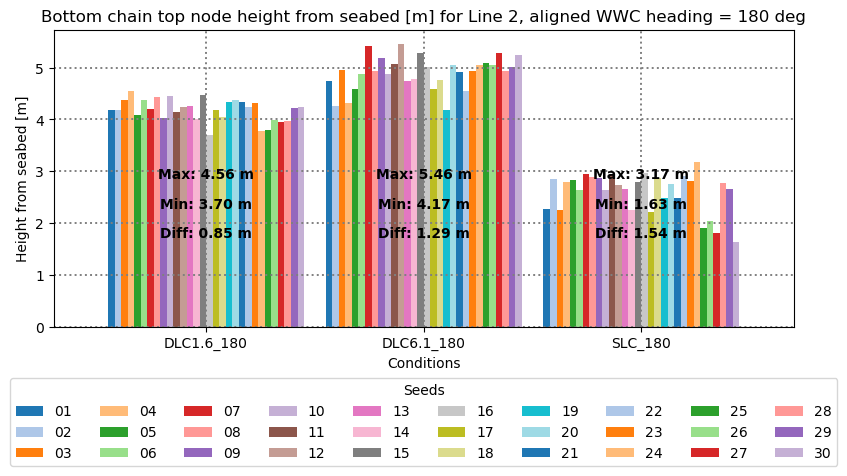

Min line tension [N] at anchor for Line 2, aligned WWC heading = 180 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.1817  | 4.17578 | 4.36426 | 4.55652 | 4.07635 | 4.37476 |
| DLC6.1_180  | 4.7384  | 4.25507 | 4.95044 | 4.32355 | 4.59186 | 4.86627 |
| SLC_180     | 2.27228 | 2.84735 | 2.24475 | 2.80029 | 2.82043 | 2.62787 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.20557 | 4.43146 | 4.02222 | 4.44519 | 4.13586 | 4.24139 |
| DLC6.1_180  | 5.41943 | 4.92944 | 5.18921 | 4.87201 | 5.07288 | 5.46112 |
| SLC_180     | 2.93921 | 2.89392 | 2.86127 | 2.63409 | 2.94116 | 2.729   |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.25531 | 4.00732 | 4.46869 | 3.70319 | 4.17523 | 4.04449 |
| DLC6.1_180  | 4.74896 | 4.7818  | 5.29004 | 5.01636 | 4.58978 | 4.75543 |
| SLC_180     | 2.64838 | 2.25256 | 2.78284 | 2.97174 | 2.21704 | 2.86078 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.34296 | 4.36841 | 4.34369 | 4.23981 | 4.31409 | 3.78247 |
| DLC6.1_180  | 4.17133 | 5.0462  | 4.91248 | 4.54181 | 4.94135 | 5.04749 |
| SLC_180     | 2.4751  | 2.75122 | 2.47998 | 2.89917 | 2.80554 | 3.16797 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 3.79614 | 3.98578 | 3.94128 | 3.97736 | 4.2193  | 4.23657 |
| DLC6.1_180  | 5.08215 | 5.04138 | 5.28284 | 4.94019 | 5.00232 | 5.24951 |
| SLC_180     | 1.90143 | 2.04486 | 1.81165 | 2.77692 | 2.65546 | 1.62946 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_180  | 3.70319 | 4.55652 |
| DLC6.1_180  | 4.17133 | 5.46112 |
| SLC_180     | 1.62946 | 3.16797 |

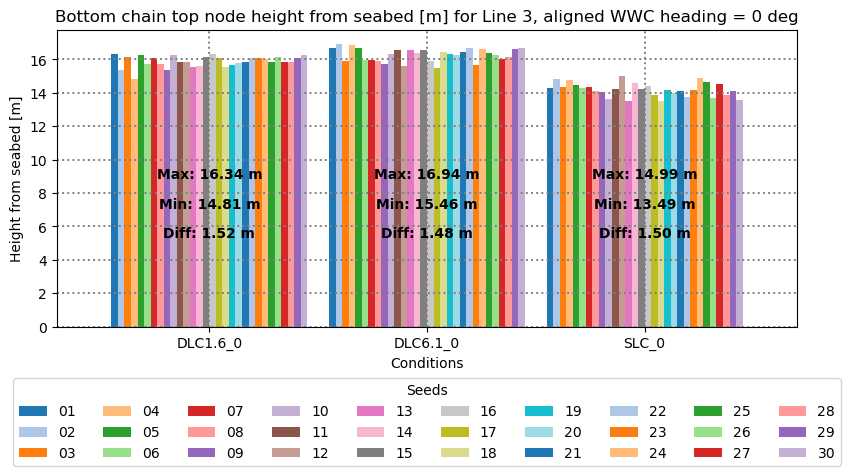

Min line tension [N] at anchor for Line 3, aligned WWC heading = 0 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.308  | 15.3616 | 16.1591 | 14.8119 | 16.2364 | 15.7501 |
| DLC6.1_0    | 16.7009 | 16.9398 | 15.8737 | 16.8682 | 16.6909 | 15.9827 |
| SLC_0       | 14.3068 | 14.8452 | 14.3157 | 14.7506 | 14.4417 | 14.2805 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.0817 | 15.7481 | 15.3806 | 16.2522 | 15.8377 | 15.8555 |
| DLC6.1_0    | 15.9906 | 15.9263 | 15.7247 | 16.3323 | 16.541  | 15.5878 |
| SLC_0       | 14.3422 | 14.111  | 14.0564 | 13.6537 | 14.2454 | 14.9853 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.5441 | 15.5972 | 16.1402 | 16.3351 | 16.1027 | 15.5435 |
| DLC6.1_0    | 16.5693 | 16.3616 | 16.5654 | 15.8904 | 15.4602 | 16.4614 |
| SLC_0       | 13.494  | 14.5577 | 14.2194 | 14.3891 | 13.8536 | 13.49   |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.6634 | 15.7876 | 15.8203 | 16.0897 | 16.1035 | 16.0285 |
| DLC6.1_0    | 16.307  | 16.2753 | 16.423  | 16.671  | 15.6574 | 16.6377 |
| SLC_0       | 14.1462 | 13.9643 | 14.0884 | 13.7692 | 14.158  | 14.914  |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.8522 | 16.1228 | 15.8428 | 15.8204 | 16.09   | 16.2535 |
| DLC6.1_0    | 16.3578 | 16.2767 | 16.0181 | 16.1584 | 16.6437 | 16.6634 |
| SLC_0       | 14.6219 | 13.6928 | 14.5393 | 13.8831 | 14.1077 | 13.5593 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 14.8119 | 16.3351 |
| DLC6.1_0    | 15.4602 | 16.9398 |
| SLC_0       | 13.49   | 14.9853 |

In [105]:
for lineID, head in linHeadDict.items():

    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()
    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Bottom chain top node height from seabed [m] for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'Height from seabed [m]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
    plt.tight_layout()

    #minimum tensions
    pivot_df['min'] = pivot_df.min(axis=1)
    pivot_df['max'] = pivot_df.max(axis=1)

    dist =  np.mean(plt.ylim()) * 0.2

    for index, row in pivot_df.iterrows():
        x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
        plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                    ha='center', color='k', weight='bold')
        plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                    ha='center', color='k', weight='bold')
        #difference
        plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                    ha='center', color='k', weight='bold')
 
        
    plt.show()

    print(f"Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg")
    displayDf(pivot_df, nCols = 6)


# Max line tension at anchor

* WWC aligned, 0 deg heading for Line 2

In [106]:
valHeader = ['ANCHTEN7', 'LINE7N0FZ', 'ANCH7HORZ']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() 
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']

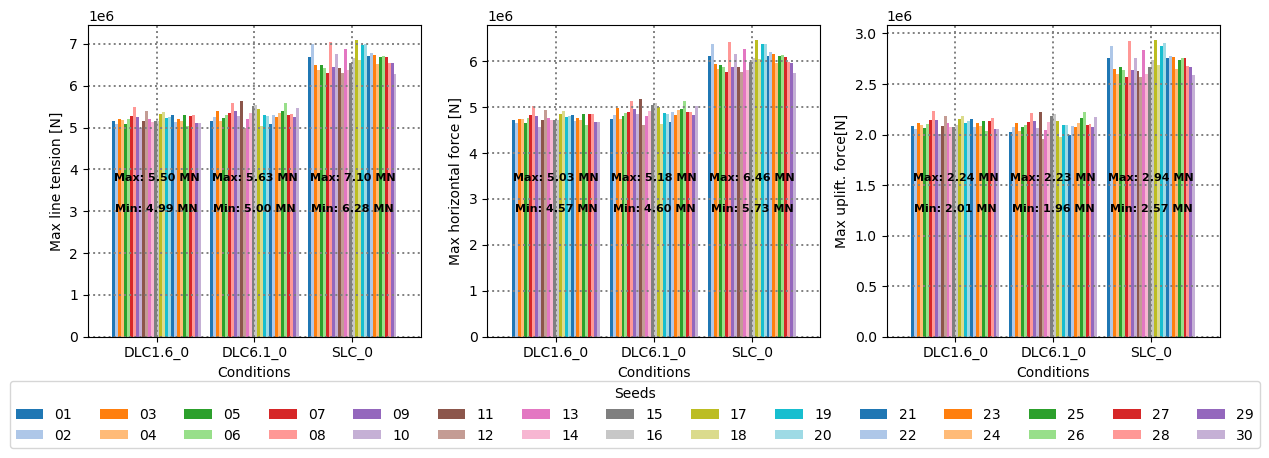

In [107]:
head = 0
filt = maxPd['heading'] == head #select the heading case based on the line considered
headFiltDf = maxPd[filt].copy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


#Line tension at anchor
lineID = 'ANCHTEN7'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, ax = axs[0], legend = False)   
plt.sca(axs[0])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max line tension [N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)



#Line horizontal tension max at anchor
lineID = 'ANCH7HORZ'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, ax = axs[1], legend = False)   
plt.sca(axs[1])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max horizontal force [N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)

#Line vertical tension max at anchor
lineID = 'LINE7N0FZ'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, legend = False, ax = axs[2])   
plt.sca(axs[2])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max uplift. force[N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title = 'Seeds', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=15)
#get the legend
fig.tight_layout()


# plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
# fig.tight_layout()



## Load inclination angle

In [108]:
#Design case
#Maximum tension at the anchor
df = df[df['heading'] == 0] 
df.loc[df.groupby('cond_head')['ANCHTEN7_[N]'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C142_L1430_clump40_DLC1.6_0_S8.outb,ANCHTEN7_[N],3338.325,5.500218e+06,23.968319,5.025930e+06,2.234359e+06
Run_P200_C142_L1430_clump40_DLC6.1_0_S11.outb,ANCHTEN7_[N],2811.675,5.634287e+06,23.258801,5.176382e+06,2.224891e+06
Run_P200_C142_L1430_clump40_SLC_0_S17.outb,ANCHTEN7_[N],2759.475,7.095421e+06,24.416498,6.460847e+06,2.933014e+06


In [109]:
df = df[df['heading'] == 0] 
#Maximum horizontal tension at the anchor
df.loc[df.groupby('cond_head')['LINE7ANCH_HOR_TEN'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C142_L1430_clump40_DLC1.6_0_S8.outb,LINE7ANCH_HOR_TEN,3338.300,5.500099e+06,23.964878,5.025983e+06,2.234021e+06
Run_P200_C142_L1430_clump40_DLC6.1_0_S11.outb,LINE7ANCH_HOR_TEN,2811.625,5.633924e+06,23.247948,5.176490e+06,2.223776e+06
Run_P200_C142_L1430_clump40_SLC_0_S17.outb,LINE7ANCH_HOR_TEN,2759.425,7.094984e+06,24.407955,6.460925e+06,2.931887e+06


In [110]:
#Maximum vertical tension at the anchor
df = df[df['heading'] == 0] 
df.loc[df.groupby('cond_head')['LINE7N0FZ_[N]'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C142_L1430_clump40_DLC1.6_0_S8.outb,LINE7N0FZ_[N],3338.500,5.497914e+06,23.990659,5.022935e+06,2.235374e+06
Run_P200_C142_L1430_clump40_DLC6.1_0_S11.outb,LINE7N0FZ_[N],2811.875,5.630597e+06,23.299442,5.171390e+06,2.227093e+06
Run_P200_C142_L1430_clump40_SLC_0_S17.outb,LINE7N0FZ_[N],2759.725,7.090351e+06,24.457360,6.454196e+06,2.935548e+06


Teh maximums are occuring at the same time - so the inclination angle does not seem to have any large effect

# Platform mean surge offset

In [111]:
valHeader = ['PtfmSurge']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']

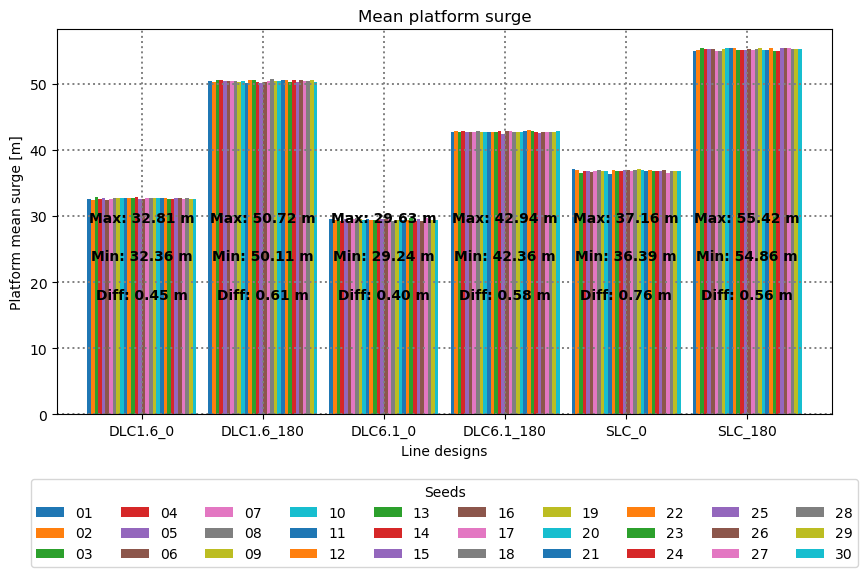

Mean platform surge [m]


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.5474 | 32.3603 | 32.8022 | 32.5362 | 32.7118 | 32.4481 |
| DLC1.6_180  | 50.4543 | 50.2517 | 50.5884 | 50.4823 | 50.4371 | 50.4427 |
| DLC6.1_0    | 29.5206 | 29.4358 | 29.5922 | 29.2375 | 29.6001 | 29.2559 |
| DLC6.1_180  | 42.6682 | 42.8726 | 42.6113 | 42.8071 | 42.6487 | 42.6834 |
| SLC_0       | 37.0116 | 36.8641 | 36.5161 | 36.8433 | 36.8461 | 36.5896 |
| SLC_180     | 54.8607 | 55.0992 | 55.3499 | 55.2648 | 55.2893 | 55.261  |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.6084 | 32.6366 | 32.67   | 32.6976 | 32.6555 | 32.6313 |
| DLC1.6_180  | 50.3598 | 50.3444 | 50.1887 | 50.4125 | 50.1532 | 50.5393 |
| DLC6.1_0    | 29.4724 | 29.6345 | 29.4532 | 29.3469 | 29.5291 | 29.3557 |
| DLC6.1_180  | 42.695  | 42.8134 | 42.7422 | 42.6708 | 42.6542 | 42.6303 |
| SLC_0       | 36.8399 | 36.9793 | 36.7293 | 36.8389 | 36.3916 | 36.8752 |
| SLC_180     | 54.9925 | 54.8751 | 55.2937 | 55.3633 | 55.3684 | 55.4045 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.6328 | 32.814  | 32.5839 | 32.6038 | 32.7184 | 32.7574 |
| DLC1.6_180  | 50.5659 | 50.2444 | 50.1141 | 50.291  | 50.3853 | 50.7204 |
| DLC6.1_0    | 29.3321 | 29.3808 | 29.4697 | 29.5371 | 29.5054 | 29.2819 |
| DLC6.1_180  | 42.6763 | 42.8704 | 42.3618 | 42.8161 | 42.8311 | 42.6533 |
| SLC_0       | 36.825  | 36.8382 | 36.9492 | 36.9596 | 36.849  | 36.9875 |
| SLC_180     | 55.1006 | 55.1196 | 55.1179 | 55.274  | 55.1035 | 55.171  |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.697  | 32.6476 | 32.6861 | 32.6508 | 32.5555 | 32.5624 |
| DLC1.6_180  | 50.3523 | 50.3319 | 50.5495 | 50.6095 | 50.2584 | 50.4635 |
| DLC6.1_0    | 29.4148 | 29.431  | 29.3948 | 29.4259 | 29.6173 | 29.2789 |
| DLC6.1_180  | 42.7317 | 42.6664 | 42.7954 | 42.9427 | 42.8621 | 42.7355 |
| SLC_0       | 37.156  | 36.9447 | 36.7517 | 36.9337 | 36.8142 | 36.8527 |
| SLC_180     | 55.4065 | 55.1196 | 55.0053 | 55.4202 | 54.9401 | 54.9363 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.6343 | 32.7057 | 32.4941 | 32.7237 | 32.6087 | 32.4857 |
| DLC1.6_180  | 50.3075 | 50.4821 | 50.3632 | 50.4472 | 50.5191 | 50.3075 |
| DLC6.1_0    | 29.5492 | 29.2906 | 29.6258 | 29.4934 | 29.3595 | 29.4365 |
| DLC6.1_180  | 42.5039 | 42.7406 | 42.6084 | 42.7408 | 42.6386 | 42.7536 |
| SLC_0       | 36.7318 | 36.9162 | 36.5448 | 36.7531 | 36.7637 | 36.7888 |
| SLC_180     | 55.3869 | 55.3897 | 55.3169 | 55.2344 | 55.295  | 55.19   |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 32.3603 | 32.814  |
| DLC1.6_180  | 50.1141 | 50.7204 |
| DLC6.1_0    | 29.2375 | 29.6345 |
| DLC6.1_180  | 42.3618 | 42.9427 |
| SLC_0       | 36.3916 | 37.156  |
| SLC_180     | 54.8607 | 55.4202 |

In [112]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='PtfmSurge')

pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Line designs')
plt.ylabel('Platform mean surge [m]')
plt.xticks(rotation=0)
plt.title('Mean platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Mean platform surge [m]')
displayDf(pivot_df, nCols = 6)

## Platform heave

In [113]:
valHeader = ['PtfmHeave']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']

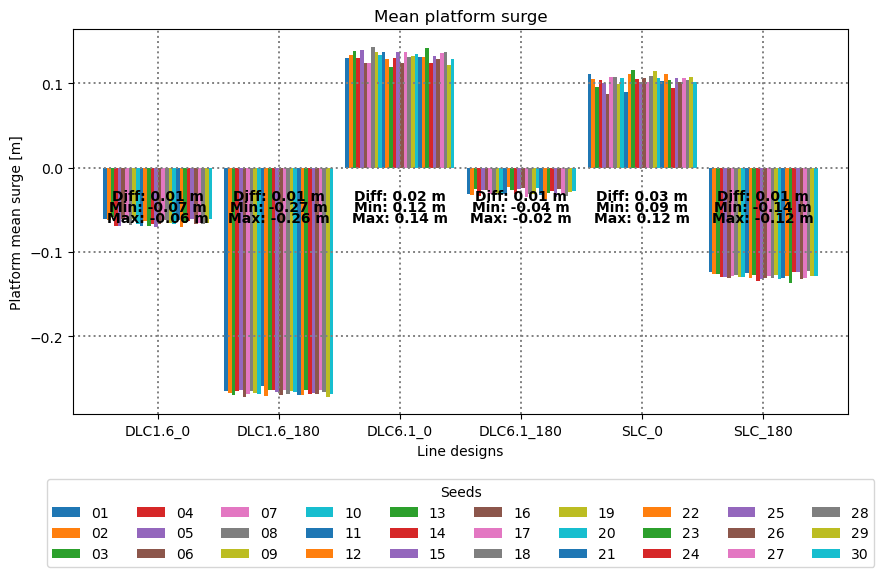

Mean platform surge [m]


| cond_head   |         01 |         02 |         03 |         04 |         05 |         06 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0607484 | -0.0617153 | -0.0583402 | -0.0694351 | -0.0696131 | -0.0612026 |
| DLC1.6_180  | -0.265089  | -0.267343  | -0.269493  | -0.264904  | -0.264341  | -0.272069  |
| DLC6.1_0    |  0.130327  |  0.133298  |  0.137933  |  0.130519  |  0.139807  |  0.123714  |
| DLC6.1_180  | -0.0310092 | -0.0323423 | -0.0258107 | -0.0340372 | -0.027037  | -0.0266729 |
| SLC_0       |  0.111246  |  0.10458   |  0.0951722 |  0.103972  |  0.0998529 |  0.0873311 |
| SLC_180     | -0.124471  | -0.126415  | -0.126813  | -0.129996  | -0.130096  | -0.131533  |

| cond_head   |         07 |         08 |         09 |         10 |         11 |         12 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0601007 | -0.0685684 | -0.0616251 | -0.0674229 | -0.069854  | -0.062906  |
| DLC1.6_180  | -0.268261  | -0.265533  | -0.268025  | -0.268961  | -0.259666  | -0.270865  |
| DLC6.1_0    |  0.124539  |  0.143165  |  0.137126  |  0.133887  |  0.137419  |  0.129169  |
| DLC6.1_180  | -0.03087   | -0.0326752 | -0.030398  | -0.0305866 | -0.0318506 | -0.0235894 |
| SLC_0       |  0.107363  |  0.10732   |  0.0985803 |  0.106742  |  0.0898891 |  0.110806  |
| SLC_180     | -0.12915   | -0.127852  | -0.130228  | -0.129923  | -0.124981  | -0.131472  |

| cond_head   |         13 |         14 |         15 |         16 |         17 |         18 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0692672 | -0.0675345 | -0.0701296 | -0.0669641 | -0.0626387 | -0.0618336 |
| DLC1.6_180  | -0.263804  | -0.264188  | -0.265841  | -0.269405  | -0.263899  | -0.269098  |
| DLC6.1_0    |  0.119593  |  0.129893  |  0.13723   |  0.123955  |  0.136825  |  0.130907  |
| DLC6.1_180  | -0.0262783 | -0.0314159 | -0.0258277 | -0.0244164 | -0.0348686 | -0.0311603 |
| SLC_0       |  0.115711  |  0.105329  |  0.101215  |  0.10673   |  0.102069  |  0.108259  |
| SLC_180     | -0.127401  | -0.134051  | -0.132657  | -0.131155  | -0.128967  | -0.131316  |

| cond_head   |         19 |         20 |         21 |         22 |         23 |         24 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0659603 | -0.0673481 | -0.0618611 | -0.0708999 | -0.0656546 | -0.0633413 |
| DLC1.6_180  | -0.265029  | -0.266092  | -0.269634  | -0.269549  | -0.264403  | -0.269163  |
| DLC6.1_0    |  0.132084  |  0.134888  |  0.130569  |  0.130738  |  0.142359  |  0.123868  |
| DLC6.1_180  | -0.031424  | -0.0245431 | -0.0329668 | -0.0378389 | -0.0303218 | -0.0281994 |
| SLC_0       |  0.114351  |  0.105766  |  0.102192  |  0.11107   |  0.104422  |  0.0947033 |
| SLC_180     | -0.1271    | -0.132665  | -0.13117   | -0.128222  | -0.137317  | -0.123538  |

| cond_head   |         25 |         26 |         27 |         28 |         29 |         30 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0612174 | -0.0674536 | -0.066036  | -0.0671657 | -0.065579  | -0.0608287 |
| DLC1.6_180  | -0.267248  | -0.269223  | -0.263985  | -0.265988  | -0.271948  | -0.268154  |
| DLC6.1_0    |  0.132484  |  0.128458  |  0.135508  |  0.136723  |  0.121068  |  0.129152  |
| DLC6.1_180  | -0.0344493 | -0.0257313 | -0.0314432 | -0.0338014 | -0.0287611 | -0.0280793 |
| SLC_0       |  0.106442  |  0.101602  |  0.106671  |  0.103709  |  0.107404  |  0.1013    |
| SLC_180     | -0.124206  | -0.132006  | -0.130864  | -0.122878  | -0.128443  | -0.128704  |

| cond_head   |        min |        max |
|:------------|-----------:|-----------:|
| DLC1.6_0    | -0.0708999 | -0.0583402 |
| DLC1.6_180  | -0.272069  | -0.259666  |
| DLC6.1_0    |  0.119593  |  0.143165  |
| DLC6.1_180  | -0.0378389 | -0.0235894 |
| SLC_0       |  0.0873311 |  0.115711  |
| SLC_180     | -0.137317  | -0.122878  |

In [114]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='PtfmHeave')

# pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
# pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
# pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Line designs')
plt.ylabel('Platform mean surge [m]')
plt.xticks(rotation=0)
plt.title('Mean platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Mean platform surge [m]')
displayDf(pivot_df, nCols = 6)

# Maximum platform surge offset

In [115]:
valHeader = ['PtfmSurge']
valType   = 'max'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']



valHeader = ['PtfmSurge']
valType   = 'min'
dataDf2               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line


dataDf3 = dataDf1.copy()
filt = dataDf3['PtfmSurge'] < 0
dataDf3.loc[filt, 'PtfmSurge'] = -1*dataDf2.loc[filt, 'PtfmSurge'] #replace the negative values with the min values, and make them positive


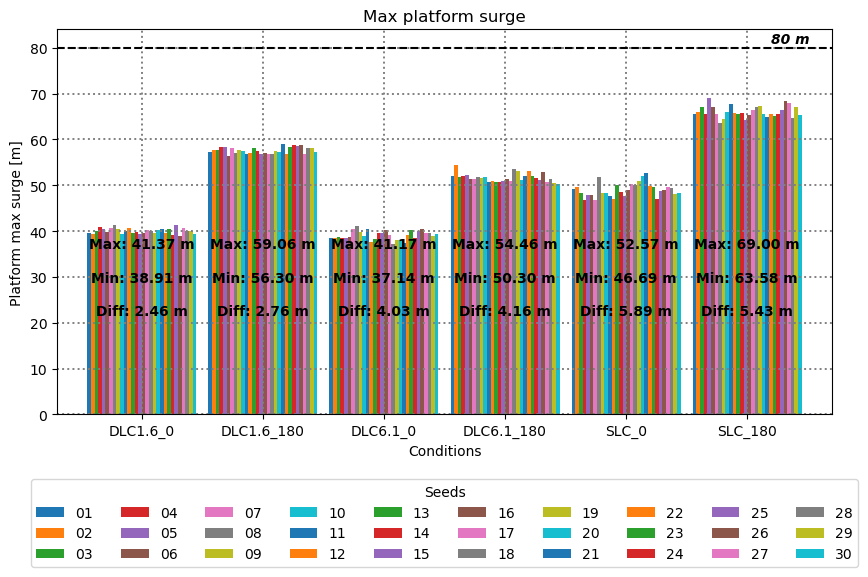

Max platform surge [m]


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 39.5204 | 39.364  | 39.8997 | 40.8722 | 40.4909 | 39.7487 |
| DLC1.6_180  | 57.3009 | 57.6477 | 57.7631 | 58.3702 | 58.2363 | 56.3032 |
| DLC6.1_0    | 38.5498 | 38.3837 | 38.7903 | 38.5329 | 38.4338 | 38.6796 |
| DLC6.1_180  | 52.0361 | 54.4599 | 51.8385 | 52.0319 | 52.3048 | 51.2717 |
| SLC_0       | 49.1837 | 49.6477 | 48.2437 | 46.6876 | 47.8034 | 47.8141 |
| SLC_180     | 65.4767 | 65.9302 | 67.1616 | 65.4394 | 69.0037 | 67.0627 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 40.6051 | 41.3682 | 40.4311 | 39.2595 | 40.0072 | 40.5794 |
| DLC1.6_180  | 58.1158 | 57.1196 | 57.6213 | 57.4788 | 56.8752 | 56.9238 |
| DLC6.1_0    | 40.3913 | 41.1687 | 39.8326 | 38.8257 | 40.3493 | 37.6989 |
| DLC6.1_180  | 51.303  | 51.887  | 51.6204 | 51.6797 | 50.5952 | 50.9024 |
| SLC_0       | 46.8721 | 51.7545 | 48.1957 | 48.189  | 47.726  | 46.9706 |
| SLC_180     | 65.5253 | 63.5785 | 64.5132 | 65.9189 | 67.7208 | 65.7862 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 39.5942 | 39.8516 | 39.3591 | 39.6069 | 40.3292 | 40.0524 |
| DLC1.6_180  | 58.2058 | 57.4095 | 56.8234 | 57.1196 | 56.8464 | 56.828  |
| DLC6.1_0    | 38.3645 | 39.6435 | 39.663  | 40.2263 | 39.1784 | 37.1369 |
| DLC6.1_180  | 50.6183 | 50.7094 | 50.9305 | 51.3434 | 50.8332 | 53.6285 |
| SLC_0       | 50.1357 | 48.4152 | 47.55   | 48.868  | 50.1693 | 50.0785 |
| SLC_180     | 65.5706 | 65.689  | 64.2362 | 65.2557 | 66.3636 | 67.0502 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 39.603  | 40.1669 | 40.5394 | 39.4863 | 40.4689 | 39.0533 |
| DLC1.6_180  | 57.5247 | 57.2637 | 59.064  | 56.6983 | 58.3411 | 58.6955 |
| DLC6.1_0    | 38.1051 | 38.0418 | 37.4026 | 39.133  | 40.1837 | 38.371  |
| DLC6.1_180  | 53.1453 | 51.077  | 52.0107 | 53.1823 | 52.031  | 51.6455 |
| SLC_0       | 50.9632 | 51.9146 | 52.573  | 49.8478 | 49.5298 | 47.066  |
| SLC_180     | 67.2768 | 65.5498 | 64.7798 | 65.5988 | 65.1273 | 65.5952 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 41.2936 | 38.9069 | 40.6665 | 40.0541 | 39.9438 | 39.2694 |
| DLC1.6_180  | 58.4875 | 58.675  | 56.7866 | 58.1948 | 58.2074 | 57.2806 |
| DLC6.1_0    | 39.9035 | 40.4078 | 39.4982 | 39.502  | 38.9481 | 39.3348 |
| DLC6.1_180  | 51.2407 | 52.8642 | 50.5912 | 51.432  | 50.5629 | 50.3044 |
| SLC_0       | 48.7396 | 48.8424 | 49.711  | 49.4459 | 48.1011 | 48.2159 |
| SLC_180     | 66.4993 | 68.3964 | 68.029  | 64.7175 | 67.1695 | 65.2789 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 38.9069 | 41.3682 |
| DLC1.6_180  | 56.3032 | 59.064  |
| DLC6.1_0    | 37.1369 | 41.1687 |
| DLC6.1_180  | 50.3044 | 54.4599 |
| SLC_0       | 46.6876 | 52.573  |
| SLC_180     | 63.5785 | 69.0037 |

In [116]:
pivot_df = dataDf3.pivot(index='cond_head', columns='seed', values='PtfmSurge')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform max surge [m]')
plt.xticks(rotation=0)
plt.title('Max platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')


plt.axhline(y =80, color='k', linestyle='--')
xLims = plt.xlim() 
plt.text(xLims[1] -.5, 81, '80 m', fontstyle='italic', color='k', weight='bold')


plt.show()

print('Max platform surge [m]')
displayDf(pivot_df, nCols = 6)



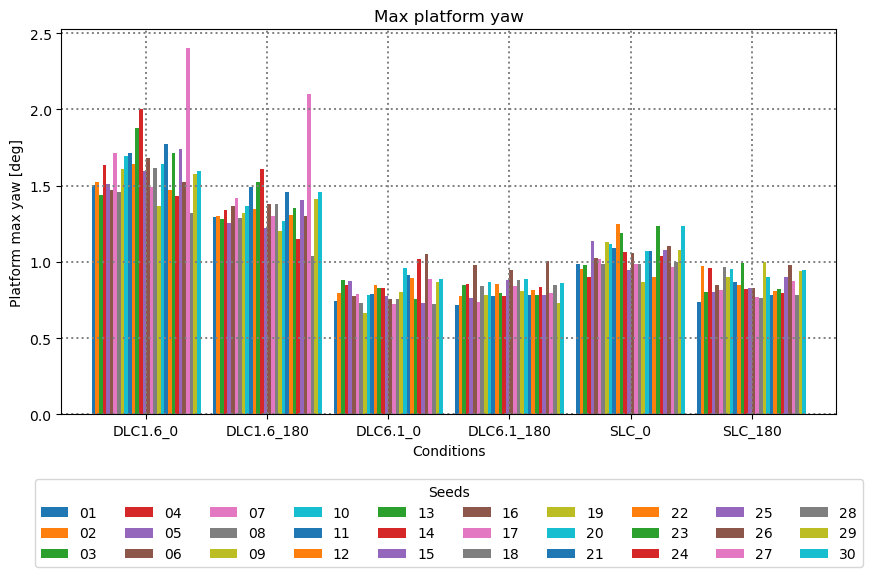

In [117]:

valHeader = ['PtfmYaw']
valType   = 'max'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']

pivot_df = dataDf1.pivot(index='cond_head', columns='seed', values='PtfmYaw')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform max yaw [deg]')
plt.xticks(rotation=0)
plt.title('Max platform yaw')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



# pivot_df['min'] = pivot_df.min(axis=1)
# pivot_df['max'] = pivot_df.max(axis=1)

# dist =  np.mean(plt.ylim()) * 0.2

# for index, row in pivot_df.iterrows():
#     x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
#     plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
#                 ha='center', color='k', weight='bold')
#     plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
#                 ha='center', color='k', weight='bold')
#     #difference
#     plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
#                 ha='center', color='k', weight='bold')

# plt.show()

# print('Max platform surge [m]')
# displayDf(pivot_df, nCols = 6)

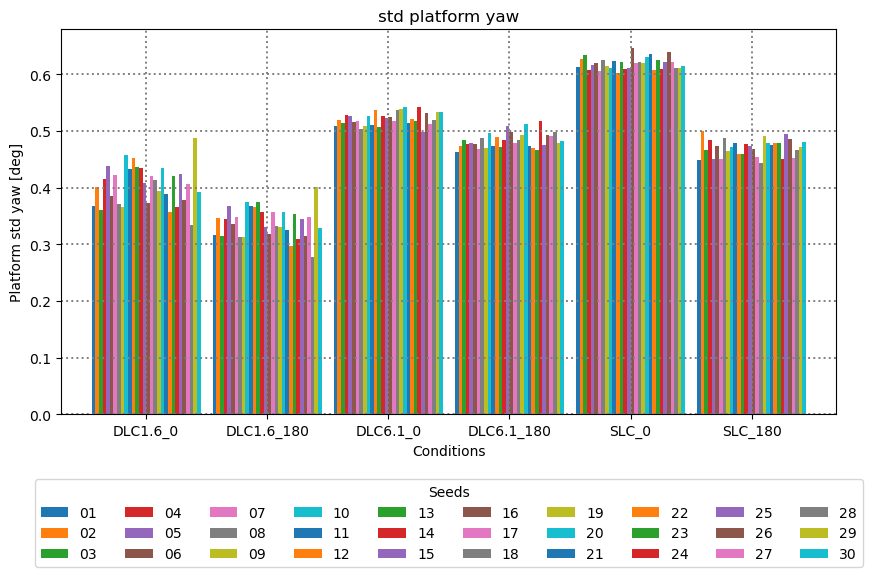

In [118]:

valHeader = ['PtfmYaw']
valType   = 'std'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']

pivot_df = dataDf1.pivot(index='cond_head', columns='seed', values='PtfmYaw')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform std yaw [deg]')
plt.xticks(rotation=0)
plt.title('std platform yaw')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")


# Tension summary

-----
Line: Line 1
Condition: DLC1.6_0, Gumbel fit loc: 1855561.23 N
-----
Line: Line 1
Condition: DLC1.6_180, Gumbel fit loc: 4511374.09 N
-----
Line: Line 1
Condition: DLC6.1_0, Gumbel fit loc: 1980859.22 N
-----
Line: Line 1
Condition: DLC6.1_180, Gumbel fit loc: 4275915.14 N
-----
Line: Line 1
Condition: SLC_0, Gumbel fit loc: 1953488.69 N
-----
Line: Line 1
Condition: SLC_180, Gumbel fit loc: 5133469.41 N
-----
Line: Line 2
Condition: DLC1.6_0, Gumbel fit loc: 5570246.70 N
-----
Line: Line 2
Condition: DLC1.6_180, Gumbel fit loc: 1415903.17 N
-----
Line: Line 2
Condition: DLC6.1_0, Gumbel fit loc: 5638721.69 N
-----
Line: Line 2
Condition: DLC6.1_180, Gumbel fit loc: 1642618.30 N
-----
Line: Line 2
Condition: SLC_0, Gumbel fit loc: 6909700.35 N
-----
Line: Line 2
Condition: SLC_180, Gumbel fit loc: 1624539.33 N
-----
Line: Line 3
Condition: DLC1.6_0, Gumbel fit loc: 1857187.63 N
-----
Line: Line 3
Condition: DLC1.6_180, Gumbel fit loc: 4519041.66 N
-----
Line: Line 3
Condition: DL

Text(2, 200000.0, '100 kN')

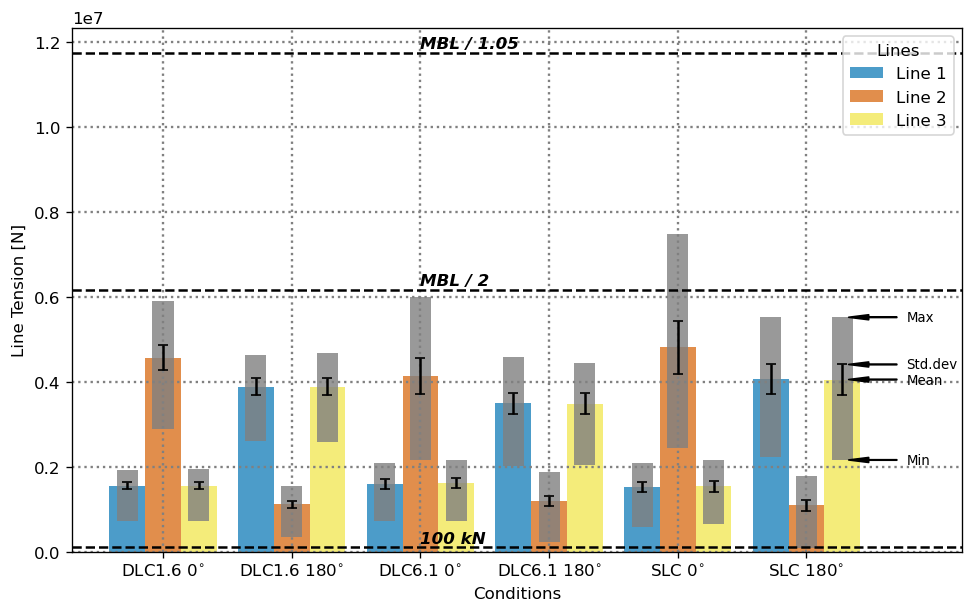

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), dpi=120, constrained_layout=True)


condList = [r'DLC1.6 $ 0 ^{\circ}$', r'DLC1.6 $ 180 ^{\circ}$', r'DLC6.1 $ 0 ^{\circ}$', r'DLC6.1 $ 180 ^{\circ}$', r'SLC $ 0 ^{\circ}$', r'SLC $ 180 ^{\circ}$']

lineNames = ['Line 1', 'Line 2', 'Line 3']
colList = ['#0072B2', '#D55E00', '#F0E442']

barWidth = 1/1.2/3


for lineInd, lineName in enumerate(lineNames):

    nums = range(1 + lineInd*6,  lineInd*6 + 1 + 6)
    nums_pattern = '|'.join(map(str, nums)) #get the regex pattern of line ID matching the ID of line segments in the slected line


    
    # print(f"Processing {lineName}...")
    for condInd, cond in enumerate(condList):

        cond_head = f"{cond.split(' ')[0]}_{cond.split(' ')[2]}"
        # print(f"  Condition: {cond_head}")
        
        condDf_filter = sumDf['cond_head'] == cond_head
        

        #Maxima 
        df = sumDf.xs("max", axis=1, level=1)
        filtered_df = df.filter(regex=rf'^(FAIRTEN(?:{nums_pattern})|ANCHTEN(?:{nums_pattern}))$').copy().loc[condDf_filter]
        maxColIdx = filtered_df.idxmax(axis=1)
        maxTenVals = filtered_df.max(axis=1).values
        if len(maxColIdx.unique())!=1: #check that for all the seeds, the maxima is occuring for same segment end
            raise ValueError(f"Warning: Multiple max tension columns found for condition {cond_head} and line {lineName}")
        # print(maxColIdx.values[0])
            

        #minima
        df = sumDf.xs("min", axis=1, level=1)
        filtered_df = df.filter(regex=rf'^(FAIRTEN(?:{nums_pattern})|ANCHTEN(?:{nums_pattern}))$').copy().loc[condDf_filter]
        minColIdx = filtered_df.idxmin(axis=1)
        minTenVals = filtered_df.min(axis=1).values
        if len(minColIdx.unique())!=1:
            raise ValueError(f"Warning: Multiple min tension columns found for condition {cond_head} and line {lineName}")
        # print(minColIdx.values[0])


        #mean
        df = sumDf.xs("mean", axis=1, level=1)
        filtered_df = df.filter(regex=rf'^(FAIRTEN(?:{nums_pattern})|ANCHTEN(?:{nums_pattern}))$').copy().loc[condDf_filter]
        meanColIdx = filtered_df.idxmax(axis=1) #pick the column where the mean is the highest --> should be the topmost node
        meanTenVals = filtered_df.max(axis=1).values
        if len(meanColIdx.unique())!= 1: #check that for all the seeds, the maxima is occuring for same segment end
            if meanColIdx.unique()[0] != maxColIdx.unique()[0]:
                raise ValueError(f"The line at which max occurs is not the same as the max of mean")

        #std
        df = sumDf.xs("std", axis=1, level=1)
        filtered_df = df[meanColIdx.unique()[0]].copy().loc[condDf_filter]
        stdTenVals = filtered_df.values

    
    
        xPos = (condInd - (len(lineNames)/2 * barWidth - 0.5*barWidth) + lineInd * barWidth)  #space out the lines

        # axs.scatter(np.ones_like(minTenVals) * xPos, maxTenVals, marker='.', s = 10, color = 'red', alpha = 0.3)
        # axs.scatter(np.ones_like(minTenVals) *xPos, minTenVals, marker='.', s = 10, color = 'green', alpha = 0.3)

        axs.bar(xPos, np.mean(meanTenVals), yerr = np.mean(stdTenVals), capsize=barWidth*10, label = lineName if condInd==0 else "", width = barWidth, color = colList[lineInd], alpha = 0.7)
        axs.bar(xPos, np.max(maxTenVals) - np.min(minTenVals), bottom = np.min(minTenVals), width = barWidth/1.7, color = 'grey', alpha = 0.8)

        
        #annotate
        if (lineInd == len(lineNames)-1) and (condInd == len(condList)-1): #only annotate for the last line and last condition to avoid clutter
    
            axs.annotate('Mean', xy=(xPos,  np.mean(meanTenVals)), xytext=(xPos + 0.5, np.mean(meanTenVals)), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3), ha='left', va='center')

            axs.annotate('Std.dev', xy=(xPos,  np.mean(meanTenVals)+np.mean(stdTenVals)), xytext=(xPos + 0.5, np.mean(meanTenVals)+np.mean(stdTenVals)), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3), ha='left', va='center')

            axs.annotate('Min', xy=(xPos,  np.min(minTenVals)), xytext=(xPos + 0.5, np.min(minTenVals)), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3), ha='left', va='center')

            axs.annotate('Max', xy=(xPos,  np.max(maxTenVals)), xytext=(xPos + 0.5, np.max(maxTenVals)), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3), ha='left', va='center')

        #PRint
        # gumbel_loc, gumbel_scale = gumbel_r.fit(maxTenVals)
        # print("-----")
        # print(f"Line: {lineName}")
        # print(f"Condition: {cond_head}, Gumbel fit loc: {gumbel_loc:.2f} N")

axs.set_xticks(range(len(condList)))
axs.set_xticklabels(condList, rotation=0)
axs.set_xlabel('Conditions')
axs.set_ylabel('Line Tension [N]')
axs.legend(title='Lines')
axs.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")


xmin, xmax = axs.get_xlim()
axs.set_xlim(xmin, xmax + 0.5)


# axs.hlines(y=polyMbl/2, xmin=xmin, xmax=3.5, color='k', linestyle='--')
# axs.hlines(y=polyMbl/1.05, xmin=3.5, xmax=xmax, color='k', linestyle='--')
axs.axhline(y=polyMbl/2, color='k', linestyle='--')
axs.text(2, 1.02 * polyMbl/2, 'MBL / 2', fontstyle='italic', color='k', weight='bold')

axs.axhline(y=polyMbl/1.05, color='k', linestyle='--')
axs.text(2, 1.01 * polyMbl/1.05, 'MBL / 1.05', fontstyle='italic', color='k', weight='bold')

# 100kN
axs.axhline(y=100e3, color='k', linestyle='--')
axs.text(2, 2 * 100e3, '100 kN', fontstyle='italic', color='k', weight='bold')



# Height summary of bottom chain node

(-0.7083333333333334, 6.208333333333334)

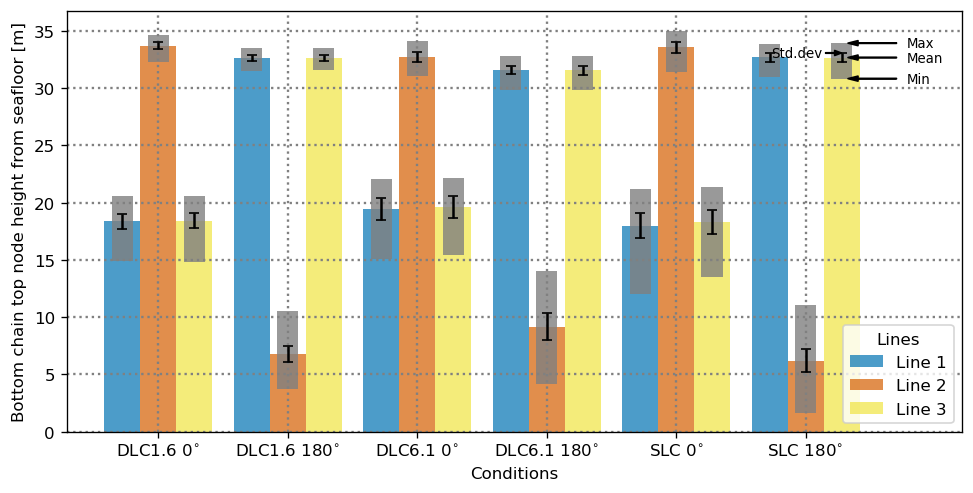

In [70]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=120, constrained_layout=True)
waterDepth = 800

condList = [r'DLC1.6 $ 0 ^{\circ}$', r'DLC1.6 $ 180 ^{\circ}$', r'DLC6.1 $ 0 ^{\circ}$', r'DLC6.1 $ 180 ^{\circ}$', r'SLC $ 0 ^{\circ}$', r'SLC $ 180 ^{\circ}$']

lineNames = ['Line 1', 'Line 2', 'Line 3']
pointId = {'Line 1': 2, 
           'Line 2': 9, 
           'Line 3': 16}

colList = ['#0072B2', '#D55E00', '#F0E442']

barWidth = 1/1.2/3


for lineInd, lineName in enumerate(lineNames):

   
    nums_pattern = str(pointId[lineName]) #get the regex pattern of line ID matching the ID of line segments in the slected line


    # print(f"Processing {lineName}...")
    for condInd, cond in enumerate(condList):

        cond_head = f"{cond.split(' ')[0]}_{cond.split(' ')[2]}"
        # print(f"  Condition: {cond_head}")        
        condDf_filter = sumDf['cond_head'] == cond_head
        

        #Maxima 
        df = sumDf.xs("max", axis=1, level=1)
        filtered_df = df.filter(regex=rf'CON{nums_pattern}PZ').copy().loc[condDf_filter]
        maxColIdx = filtered_df.idxmax(axis=1)
        maxTenVals = filtered_df.max(axis=1).values + waterDepth
        if len(maxColIdx.unique())!=1: #check that for all the seeds, the maxima is occuring for same segment end
            raise ValueError(f"Warning: Multiple max tension columns found for condition {cond_head} and line {lineName}")
        # print(maxColIdx.values)
            

        #minima
        df = sumDf.xs("min", axis=1, level=1)
        filtered_df = df.filter(regex=rf'CON{nums_pattern}PZ').copy().loc[condDf_filter]
        minColIdx = filtered_df.idxmin(axis=1)
        minTenVals = filtered_df.min(axis=1).values + waterDepth
        if len(minColIdx.unique())!=1:
            raise ValueError(f"Warning: Multiple min tension columns found for condition {cond_head} and line {lineName}")
        # print(minColIdx.values[0])


        #mean
        df = sumDf.xs("mean", axis=1, level=1)
        filtered_df = df.filter(regex=rf'CON{nums_pattern}PZ').copy().loc[condDf_filter]
        meanColIdx = filtered_df.idxmax(axis=1) #pick the column where the mean is the highest --> should be the topmost node
        meanTenVals = filtered_df.max(axis=1).values + waterDepth
        if len(meanColIdx.unique())!= 1: #check that for all the seeds, the maxima is occuring for same segment end
            if meanColIdx.unique()[0] != maxColIdx.unique()[0]:
                raise ValueError(f"The line at which max occurs is not the same as the max of mean")

        #std
        df = sumDf.xs("std", axis=1, level=1)
        filtered_df = df[meanColIdx.unique()[0]].copy().loc[condDf_filter]
        stdTenVals = filtered_df.values

    
    
        xPos = (condInd - (len(lineNames)/2 * barWidth - 0.5*barWidth) + lineInd * barWidth)  #space out the lines

        # axs.scatter(np.ones_like(minTenVals) * xPos, maxTenVals, marker='.', s = 10, color = 'red', alpha = 0.3)
        # axs.scatter(np.ones_like(minTenVals) *xPos, minTenVals, marker='.', s = 10, color = 'green', alpha = 0.3)

        axs.bar(xPos, np.mean(meanTenVals), yerr = np.mean(stdTenVals), capsize=barWidth*10, label = lineName if condInd==0 else "", width = barWidth, color = colList[lineInd], alpha = 0.7)
        axs.bar(xPos, np.max(maxTenVals) - np.min(minTenVals), bottom = np.min(minTenVals), width = barWidth/1.7, color = 'grey', alpha = 0.8)

        
        #annotate
        if (lineInd == len(lineNames)-1) and (condInd == len(condList)-1): #only annotate for the last line and last condition to avoid clutter
    
            axs.annotate('Mean', xy=(xPos,  np.mean(meanTenVals)), xytext=(xPos + 0.5, np.mean(meanTenVals)), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3, headlength=6), ha='left', va='center')

            axs.annotate('Std.dev', xy=(xPos,  np.mean(meanTenVals)+np.mean(stdTenVals)), xytext=(xPos - 0.15, np.mean(meanTenVals)+np.mean(stdTenVals)), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.3, headwidth=3, headlength=4), ha='right', va='center')

            axs.annotate('Min', xy=(xPos,  np.min(minTenVals)), xytext=(xPos + 0.5, np.min(minTenVals)), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3, headlength=6), ha='left', va='center')

            axs.annotate('Max', xy=(xPos,  np.max(maxTenVals)), xytext=(xPos + 0.5, np.max(maxTenVals)), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3, headlength=6), ha='left', va='center')

        #PRint
        # gumbel_loc, gumbel_scale = gumbel_r.fit(maxTenVals)
        # print("-----")
        # print(f"Line: {lineName}")
        # print(f"Condition: {cond_head}, Gumbel fit loc: {gumbel_loc:.2f} N")

axs.set_xticks(range(len(condList)))
axs.set_xticklabels(condList, rotation=0)
axs.set_xlabel('Conditions')
axs.set_ylabel('Bottom chain top node height from seafloor [m]')
axs.legend(title='Lines')
axs.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")


xmin, xmax = axs.get_xlim()
axs.set_xlim(xmin, xmax + 0.5)


# axs.hlines(y=polyMbl/2, xmin=xmin, xmax=3.5, color='k', linestyle='--')
# axs.hlines(y=polyMbl/1.05, xmin=3.5, xmax=xmax, color='k', linestyle='--')
# axs.axhline(y=polyMbl/2, color='k', linestyle='--')
# axs.text(2, 1.02 * polyMbl/2, 'MBL / 2', fontstyle='italic', color='k', weight='bold')

# axs.axhline(y=polyMbl/1.05, color='k', linestyle='--')
# axs.text(2, 1.01 * polyMbl/1.05, 'MBL / 1.05', fontstyle='italic', color='k', weight='bold')

# # 100kN
# axs.axhline(y=100e3, color='k', linestyle='--')
# axs.text(2, 2 * 100e3, '100 kN', fontstyle='italic', color='k', weight='bold')



# Platform motion summary

Text(2.5, 81, '80 m')

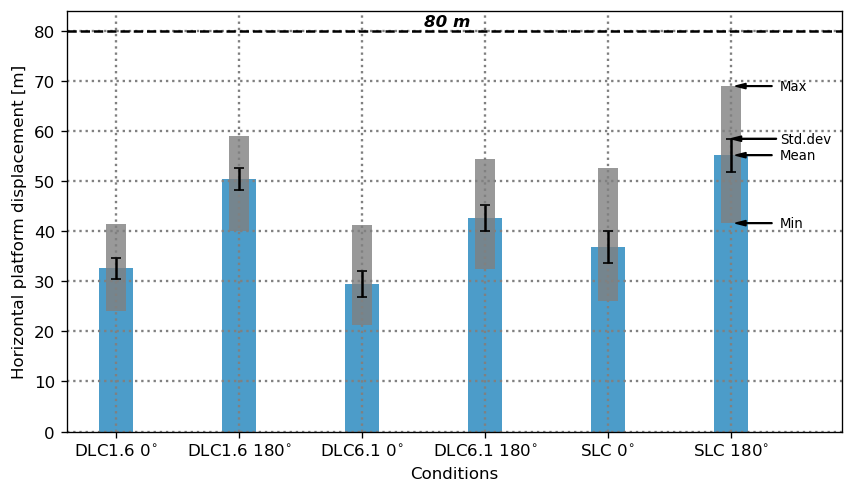

In [93]:
fig, axs = plt.subplots(1, 1, figsize=(7, 4), dpi=120, constrained_layout=True)
# waterDepth = 800

condList = [r'DLC1.6 $ 0 ^{\circ}$', r'DLC1.6 $ 180 ^{\circ}$', r'DLC6.1 $ 0 ^{\circ}$', r'DLC6.1 $ 180 ^{\circ}$', r'SLC $ 0 ^{\circ}$', r'SLC $ 180 ^{\circ}$']

# lineNames = ['Line 1', 'Line 2', 'Line 3']
# pointId = {'Line 1': 2, 
#            'Line 2': 9, 
#            'Line 3': 16}


colList = ['#0072B2', '#D55E00', '#F0E442']

barWidth = 1/1.2/3


# print(f"Processing {lineName}...")
for condInd, cond in enumerate(condList):

    cond_head = f"{cond.split(' ')[0]}_{cond.split(' ')[2]}"
    # print(f"  Condition: {cond_head}")        
    condDf_filter = sumDf['cond_head'] == cond_head
    
    if cond.split(' ')[2] == '180':
        signFact = -1
    else:
        signFact = 1

    #Maxima 
    df = sumDf.xs("max", axis=1, level=1)
    filtered_df = df.filter(regex=rf'PtfmSurge').copy().loc[condDf_filter]
    maxColIdx = filtered_df.idxmax(axis=1)
    maxTenVals = filtered_df.max(axis=1).values 
    if len(maxColIdx.unique())!=1: #check that for all the seeds, the maxima is occuring for same segment end
        raise ValueError(f"Warning: Multiple max tension columns found for condition {cond_head} and line {lineName}")
    # print(maxColIdx.values)
        

    #minima
    df = sumDf.xs("min", axis=1, level=1)
    filtered_df = df.filter(regex=rf'PtfmSurge').copy().loc[condDf_filter]
    minColIdx = filtered_df.idxmin(axis=1)
    minTenVals = filtered_df.min(axis=1).values 
    if len(minColIdx.unique())!=1:
        raise ValueError(f"Warning: Multiple min tension columns found for condition {cond_head} and line {lineName}")
    # print(minColIdx.values[0])

    if signFact == -1:
        minTenVals_cpy = minTenVals.copy()
        minTenVals = -1 * maxTenVals
        maxTenVals = -1 * minTenVals_cpy

    #mean
    df = sumDf.xs("mean", axis=1, level=1)
    filtered_df = df.filter(regex=rf'PtfmSurge').copy().loc[condDf_filter]
    meanColIdx = filtered_df.idxmax(axis=1) #pick the column where the mean is the highest --> should be the topmost node
    meanTenVals = filtered_df.max(axis=1).values * signFact
    if len(meanColIdx.unique())!= 1: #check that for all the seeds, the maxima is occuring for same segment end
        if meanColIdx.unique()[0] != maxColIdx.unique()[0]:
            raise ValueError(f"The line at which max occurs is not the same as the max of mean")

    #std
    df = sumDf.xs("std", axis=1, level=1)
    filtered_df = df[meanColIdx.unique()[0]].copy().loc[condDf_filter]
    stdTenVals = filtered_df.values



    # xPos = (condInd - (len(lineNames)/2 * barWidth - 0.5*barWidth) + lineInd * barWidth)  #space out the lines
    xPos = condInd

    # axs.scatter(np.ones_like(minTenVals) * xPos, maxTenVals, marker='.', s = 10, color = 'red', alpha = 0.3)
    # axs.scatter(np.ones_like(minTenVals) *xPos, minTenVals, marker='.', s = 10, color = 'green', alpha = 0.3)

    axs.bar(xPos, np.mean(meanTenVals), yerr = np.mean(stdTenVals), capsize=barWidth*10,  width = barWidth, color = colList[0], alpha = 0.7)
    axs.bar(xPos, np.max(maxTenVals) - np.min(minTenVals), bottom = np.min(minTenVals), width = barWidth/1.7, color = 'grey', alpha = 0.8)

    
    #annotate
    if (lineInd == len(lineNames)-1) and (condInd == len(condList)-1): #only annotate for the last line and last condition to avoid clutter

        axs.annotate('Mean', xy=(xPos,  np.mean(meanTenVals)), xytext=(xPos + 0.4, np.mean(meanTenVals)), size=8,
                        arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3, headlength=6), ha='left', va='center')

        axs.annotate('Std.dev', xy=(xPos,  np.mean(meanTenVals)+np.mean(stdTenVals)), xytext=(xPos + 0.4, np.mean(meanTenVals)+np.mean(stdTenVals)), size=8,
                        arrowprops=dict(facecolor='black', shrink=0.01, width=0.3, headwidth=3, headlength=6), ha='left', va='center')

        axs.annotate('Min', xy=(xPos,  np.min(minTenVals)), xytext=(xPos + 0.4, np.min(minTenVals)), size=8,
                        arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3, headlength=6), ha='left', va='center')

        axs.annotate('Max', xy=(xPos,  np.max(maxTenVals)), xytext=(xPos + 0.4, np.max(maxTenVals)), size=8,
                        arrowprops=dict(facecolor='black', shrink=0.1, width=0.3, headwidth=3, headlength=6), ha='left', va='center')

    #PRint
    # gumbel_loc, gumbel_scale = gumbel_r.fit(maxTenVals)
    # print("-----")
    # print(f"Line: {lineName}")
    # print(f"Condition: {cond_head}, Gumbel fit loc: {gumbel_loc:.2f} N")

axs.set_xticks(range(len(condList)))
axs.set_xticklabels(condList, rotation=0)
axs.set_xlabel('Conditions')
axs.set_ylabel('Horizontal platform displacement [m]')
# axs.legend(title='Lines')
axs.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")


xmin, xmax = axs.get_xlim()
axs.set_xlim(xmin, xmax + 0.5)

# ymin, ymax = axs.get_ylim()
# axs.set_ylim(ymin, ymax + 1)

plt.axhline(y =80, color='k', linestyle='--')
plt.text(2.5, 81, '80 m', fontstyle='italic', color='k', weight='bold')


# axs.hlines(y=polyMbl/2, xmin=xmin, xmax=3.5, color='k', linestyle='--')
# axs.hlines(y=polyMbl/1.05, xmin=3.5, xmax=xmax, color='k', linestyle='--')
# axs.axhline(y=polyMbl/2, color='k', linestyle='--')
# axs.text(2, 1.02 * polyMbl/2, 'MBL / 2', fontstyle='italic', color='k', weight='bold')

# axs.axhline(y=polyMbl/1.05, color='k', linestyle='--')
# axs.text(2, 1.01 * polyMbl/1.05, 'MBL / 1.05', fontstyle='italic', color='k', weight='bold')

# # 100kN
# axs.axhline(y=100e3, color='k', linestyle='--')
# axs.text(2, 2 * 100e3, '100 kN', fontstyle='italic', color='k', weight='bold')

